## This 'GraphFinder' class does the following:
- Read a single sto file or a directory with sto files.     
- recognize different types of information from the file.     
- Build a general graph (with all info encoded in the node).  
- Remodel the graph with the desired info given by the user.  

In [1]:
%matplotlib inline
import os, sys
import subprocess as sp
from itertools import cycle
import networkx as nx
import re
import ntpath
import shutil
import fnmatch
from eden.util import display
# -----------------------------------------------------------------------------

class GraphFinder(object):
    def __init__(self):
        pass
    '''read a Sto file separate the extract the interesting information from the file
    it takes the file path and returns the head which is the information type and it's sequence'''

    def _read_sto_file(self, file_path =None):
        head_mark0 = '#'
        head_mark1 = '='
        head_mark2 = 'G'
        head_mark3 = 'C'
        head_list = []
        sequence_list = []  

        read_file = open(file_path ,'r') 
        for line in read_file: 
            lines = list(line)
                # the read line is the head of the sequence write it in head list
            if lines[0] == head_mark0 and lines[1] == head_mark1 and lines[2] == head_mark2 and lines[3] == head_mark3:
                line = line.strip('#=GC ')            
                line = line.strip('\n')
                line = line.split(' ')
                line = filter(None, line)

                head = line[0]
                head_list.append(head)
                sequence = line[1].split()
                sequence_list.append(sequence)
                zip_head_seqs = zip(head_list, sequence_list)

        return zip_head_seqs
    

    '''recognize the different types of information extracted from step1
    it takes the zipped info from the funtion '_readStoFile' and returns a dictionary 
        that identify every type of information'''

    def _identify_information_type(self, file_name, head_seq_list):

        secondery_structure_s = []
        conservation_s = []
        conservation_stringth_s = []
        entropy_0_s = []
        entropy_1_s = []
        entropy_2_s = []
        entropy_3_s = []
        coveriation_s = []

        for i, elemant in enumerate(head_seq_list):
            info_item = head_seq_list[i]

            if info_item[0] == 'SS_cons':
                secondery_structure_s.append(str(info_item[1]))

            if info_item[0] == 'cons':
                conservation_s.append(str(info_item[1]))

            if info_item[0] == 'conss':
                conservation_stringth_s.append(info_item[1])

            if info_item[0] == 'col_entropy_0':
                entropy_0_s.append(info_item[1])

            if info_item[0] == 'col_entropy_1':
                entropy_1_s.append(info_item[1])

            if info_item[0] == 'col_entropy_2':
                entropy_2_s.append(info_item[1])

            if info_item[0] == 'col_entropy_3':
                entropy_3_s.append(info_item[1])   

            if info_item[0] == 'cov_SS_cons':
                coveriation_s.append(info_item[1])

        file_dictionary = {"ID_file name": file_name, "conservation": conservation_s, "secondery_structure": secondery_structure_s,
                           "conservation_stringth": conservation_stringth_s, "entropy_3": entropy_3_s, "covariation": coveriation_s}
        return file_dictionary

    
    def _filter_info(self, info_type):
        sequence = info_type['conservation']
        structure = info_type['secondery_structure']
        conservation_stringth = info_type['conservation_stringth']
        covariation = info_type['covariation']
        entropy_3 = info_type['entropy_3']

        sequence = sequence[0].strip('[\']')
        #print ('seq', sequence)
        structure = structure[0].strip('[\']')
        #print ('stru', structure)
        conservation_stringth = str(conservation_stringth[0]).strip('[\']')
        covariation = str(covariation).strip('[\']')
        entropy_3 = str(entropy_3[0]).strip('[\']')

        zip_info_type = zip(sequence,conservation_stringth,covariation,entropy_3)
        return sequence, structure, conservation_stringth, covariation, entropy_3
    

    '''build a Networkx graph with all type of info (the most general graph)
    this graph identifies the basepair relation beside the next relation between the nodes
    transform the general graph to the wanted graph based on parameters passed by the '_graphParametersList' function
    '''
    def _build_graph(self, head, sequence, structure, conservation_stringth, covariation, entropy_3):

        #print ("Graph title", head)
        open_pran = "<" or "(" or "[" or "{"
        close_pran = ">" or ")" or "]" or "}"
        stack_o = []
        stack_pos_o =[]
        stack_c = []
        G = nx.Graph()

        for i, k in enumerate(structure):

            #node labeled with all info
            seqCovConssEnt = sequence[i] + covariation[i] + conservation_stringth[i] + entropy_3[i]
            G.add_node(i, label = seqCovConssEnt)

            # connect with the next node 
            if i > 0:
                G.add_edge(i-1, i, label= 'x')

            """find basepair and connect them"""
            if structure[i] == open_pran:
                j = i
                stack_o.append(structure[j])
                stack_pos_o.append(j)
                open_len = len(stack_o)

            if structure[i] == close_pran:
                stack_c.append(structure[i])
                stack_o.pop()
                j = stack_pos_o.pop()
                G.add_edge(i, j, label = 'b')
        return G 


    def _remodel_graph(self, head, sequence, structure, conservation_stringth, covariation, entropy_3):

        #print ("Graph title", head)
        open_pran = "<" or "(" or "[" or "{"
        close_pran = ">" or ")" or "]" or "}"
        stack_o = []
        stack_pos_o =[]
        stack_c = []

        G = nx.Graph()
        G.graph['graph_title']= head
        #print G.graph


        for i, k in enumerate(structure):
            G.add_node(i)
 
            G.node[i]['key'] = sequence[i] + covariation[i] + conservation_stringth[i] + entropy_3[i]
            G.node[i]['seq'] = sequence[i]
            G.node[i]['cov'] = covariation[i]
            G.node[i]['cor'] = conservation_stringth[i]
            G.node[i]['ent'] = entropy_3[i]

            G.add_node(i, label = G.node[i]['key'])

            # connect with the next node 
            if i > 0:
                G.add_edge(i-1, i, label= 'x')

            """find basepair and connect them"""
            if structure[i] == open_pran:
                j = i
                stack_o.append(structure[j])
                stack_pos_o.append(j)
                open_len = len(stack_o)

            if structure[i] == close_pran:
                stack_c.append(structure[i])
                stack_o.pop()
                j = stack_pos_o.pop()
                G.add_edge(i, j, label = 'b')
        return G 
    

    '''regenerating the graph with the disered info'''
    def remodel(self, G, use_seq=True, use_cov = True, use_cor = True, use_ent = True):
        for i in G.nodes():
            if use_seq:
                G.node[i]['label'] = G.node[i]['seq']
               
            if use_cov:
                G.node[i]['label'] = G.node[i]['cov']
            
            if use_cor:
                G.node[i]['label'] = G.node[i]['cor']
                
            if use_ent:
                G.node[i]['label'] = G.node[i]['ent']
        
            if use_seq and use_cov:
                G.node[i]['label'] = G.node[i]['seq'] + G.node[i]['cov']
            
            if use_seq and use_cor:
                G.node[i]['label'] = G.node[i]['seq'] + G.node[i]['cor']
                
            if use_seq and use_cor and use_cov and use_ent:
                G.node[i]['label'] = G.node[i]['seq'] + G.node[i]['cor'] + G.node[i]['cov'] + G.node[i]['ent']
                
        return G

    
    '''Read one file
       -------------
    read one STO file, extract the desired info, and then build the graph
    it takes the STO file path and returns it's graph'''

    def file_to_graph_convertor(self, file_path=None):
        head = ntpath.splitext(ntpath.basename(file_path))[0]
        zip_head_seqs = self._read_sto_file(file_path)
        #print zip_head_seqs
        info_type = self._identify_information_type(head, zip_head_seqs)
        sequence, structure, conservation_stringth, covariation, entropy_3 = self._filter_info(info_type)
        #graph = self._build_graph(head, sequence, structure, conservation_stringth, covariation, entropy_3)
        graph = self._remodel_graph(head, sequence, structure, conservation_stringth, covariation, entropy_3)
        
        return graph

    '''Read a directory
       ----------------
    read a folder of STO files and then call '_FileToGraphWrapper' function
    it taked the directory path and returns list of their's graphs'''

    def folder_to_graph_convertor(self, directory = None):
        graph_list = []
        for file_name in os.listdir(directory):
            file_complete_path = os.path.join(directory, file_name)
            graphs = self.file_to_graph_convertor(file_complete_path)
            graph_list += [graphs.copy()]
        return graph_list

## Experiments:

#### read a single '.sto' file and create its graph

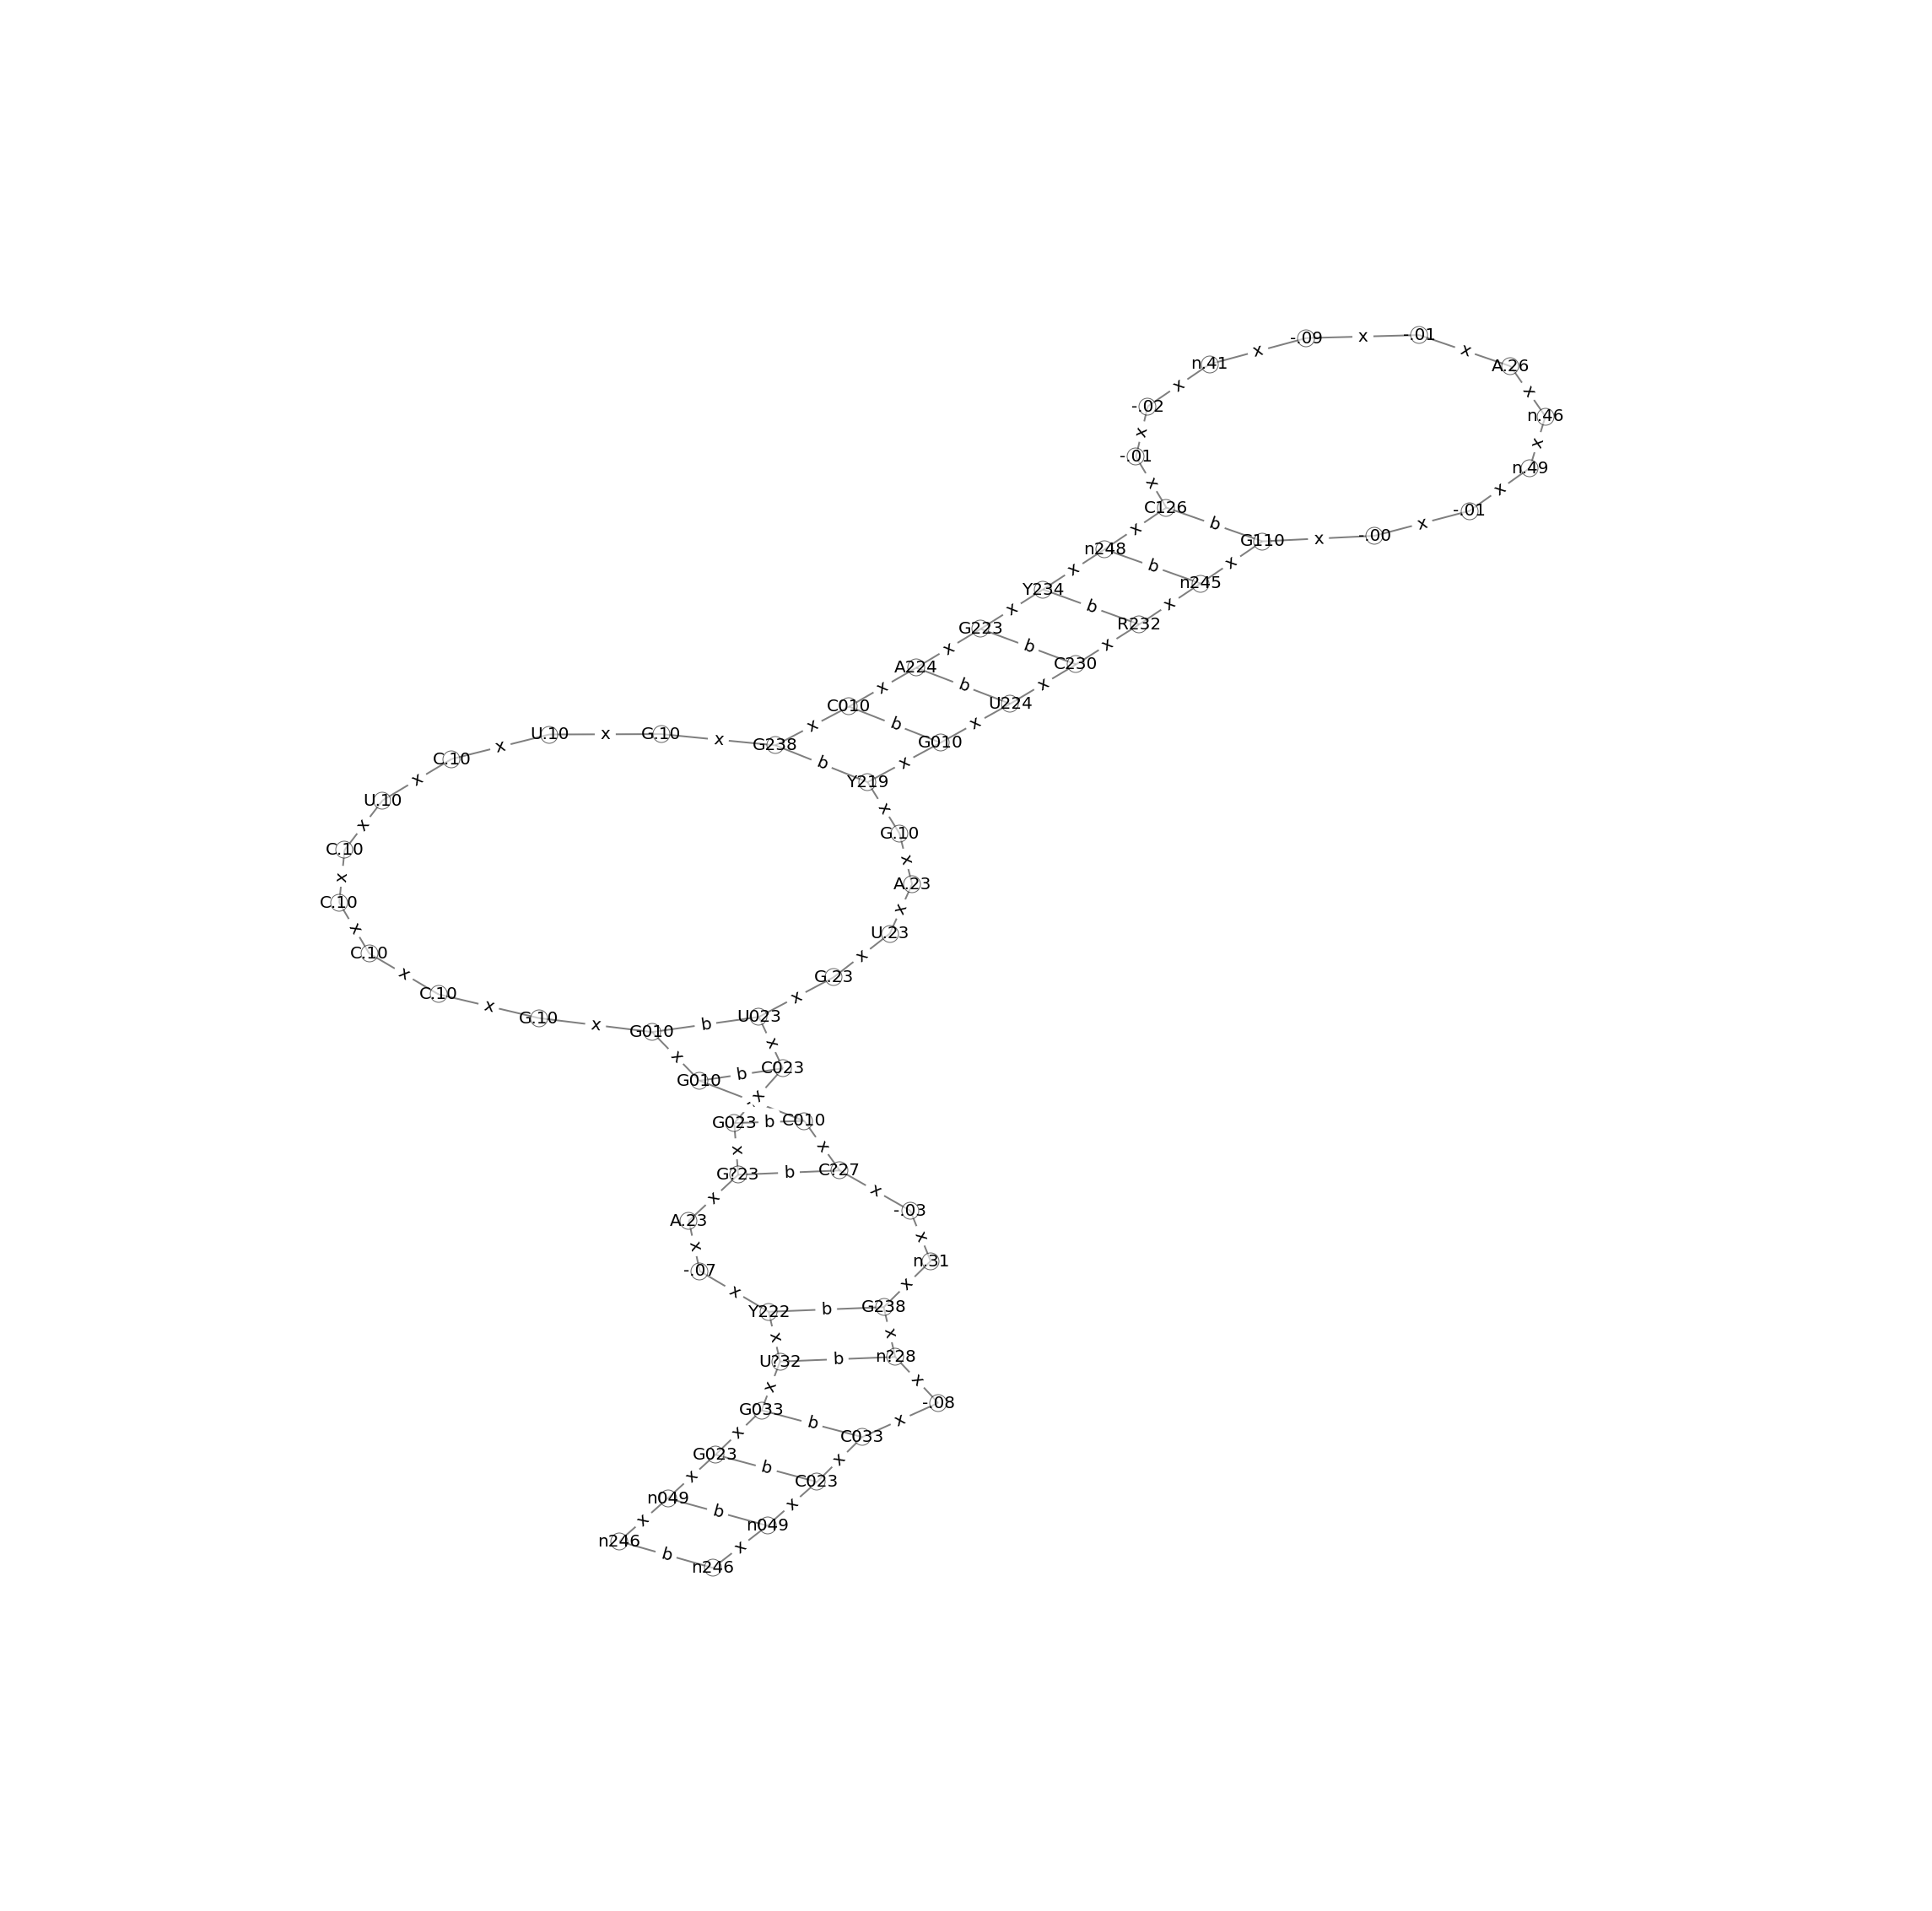

In [2]:
file_path = "StoExamples/StoExmapleSmall/positives-sto/550-53949-1-0.sto"
abs_path = os.path.abspath(file_path)
gf = GraphFinder()
Graph = gf.file_to_graph_convertor(file_path)
display.draw_graph(Graph, size=40, node_size=400, font_size=20, node_border=True, prog='neato')

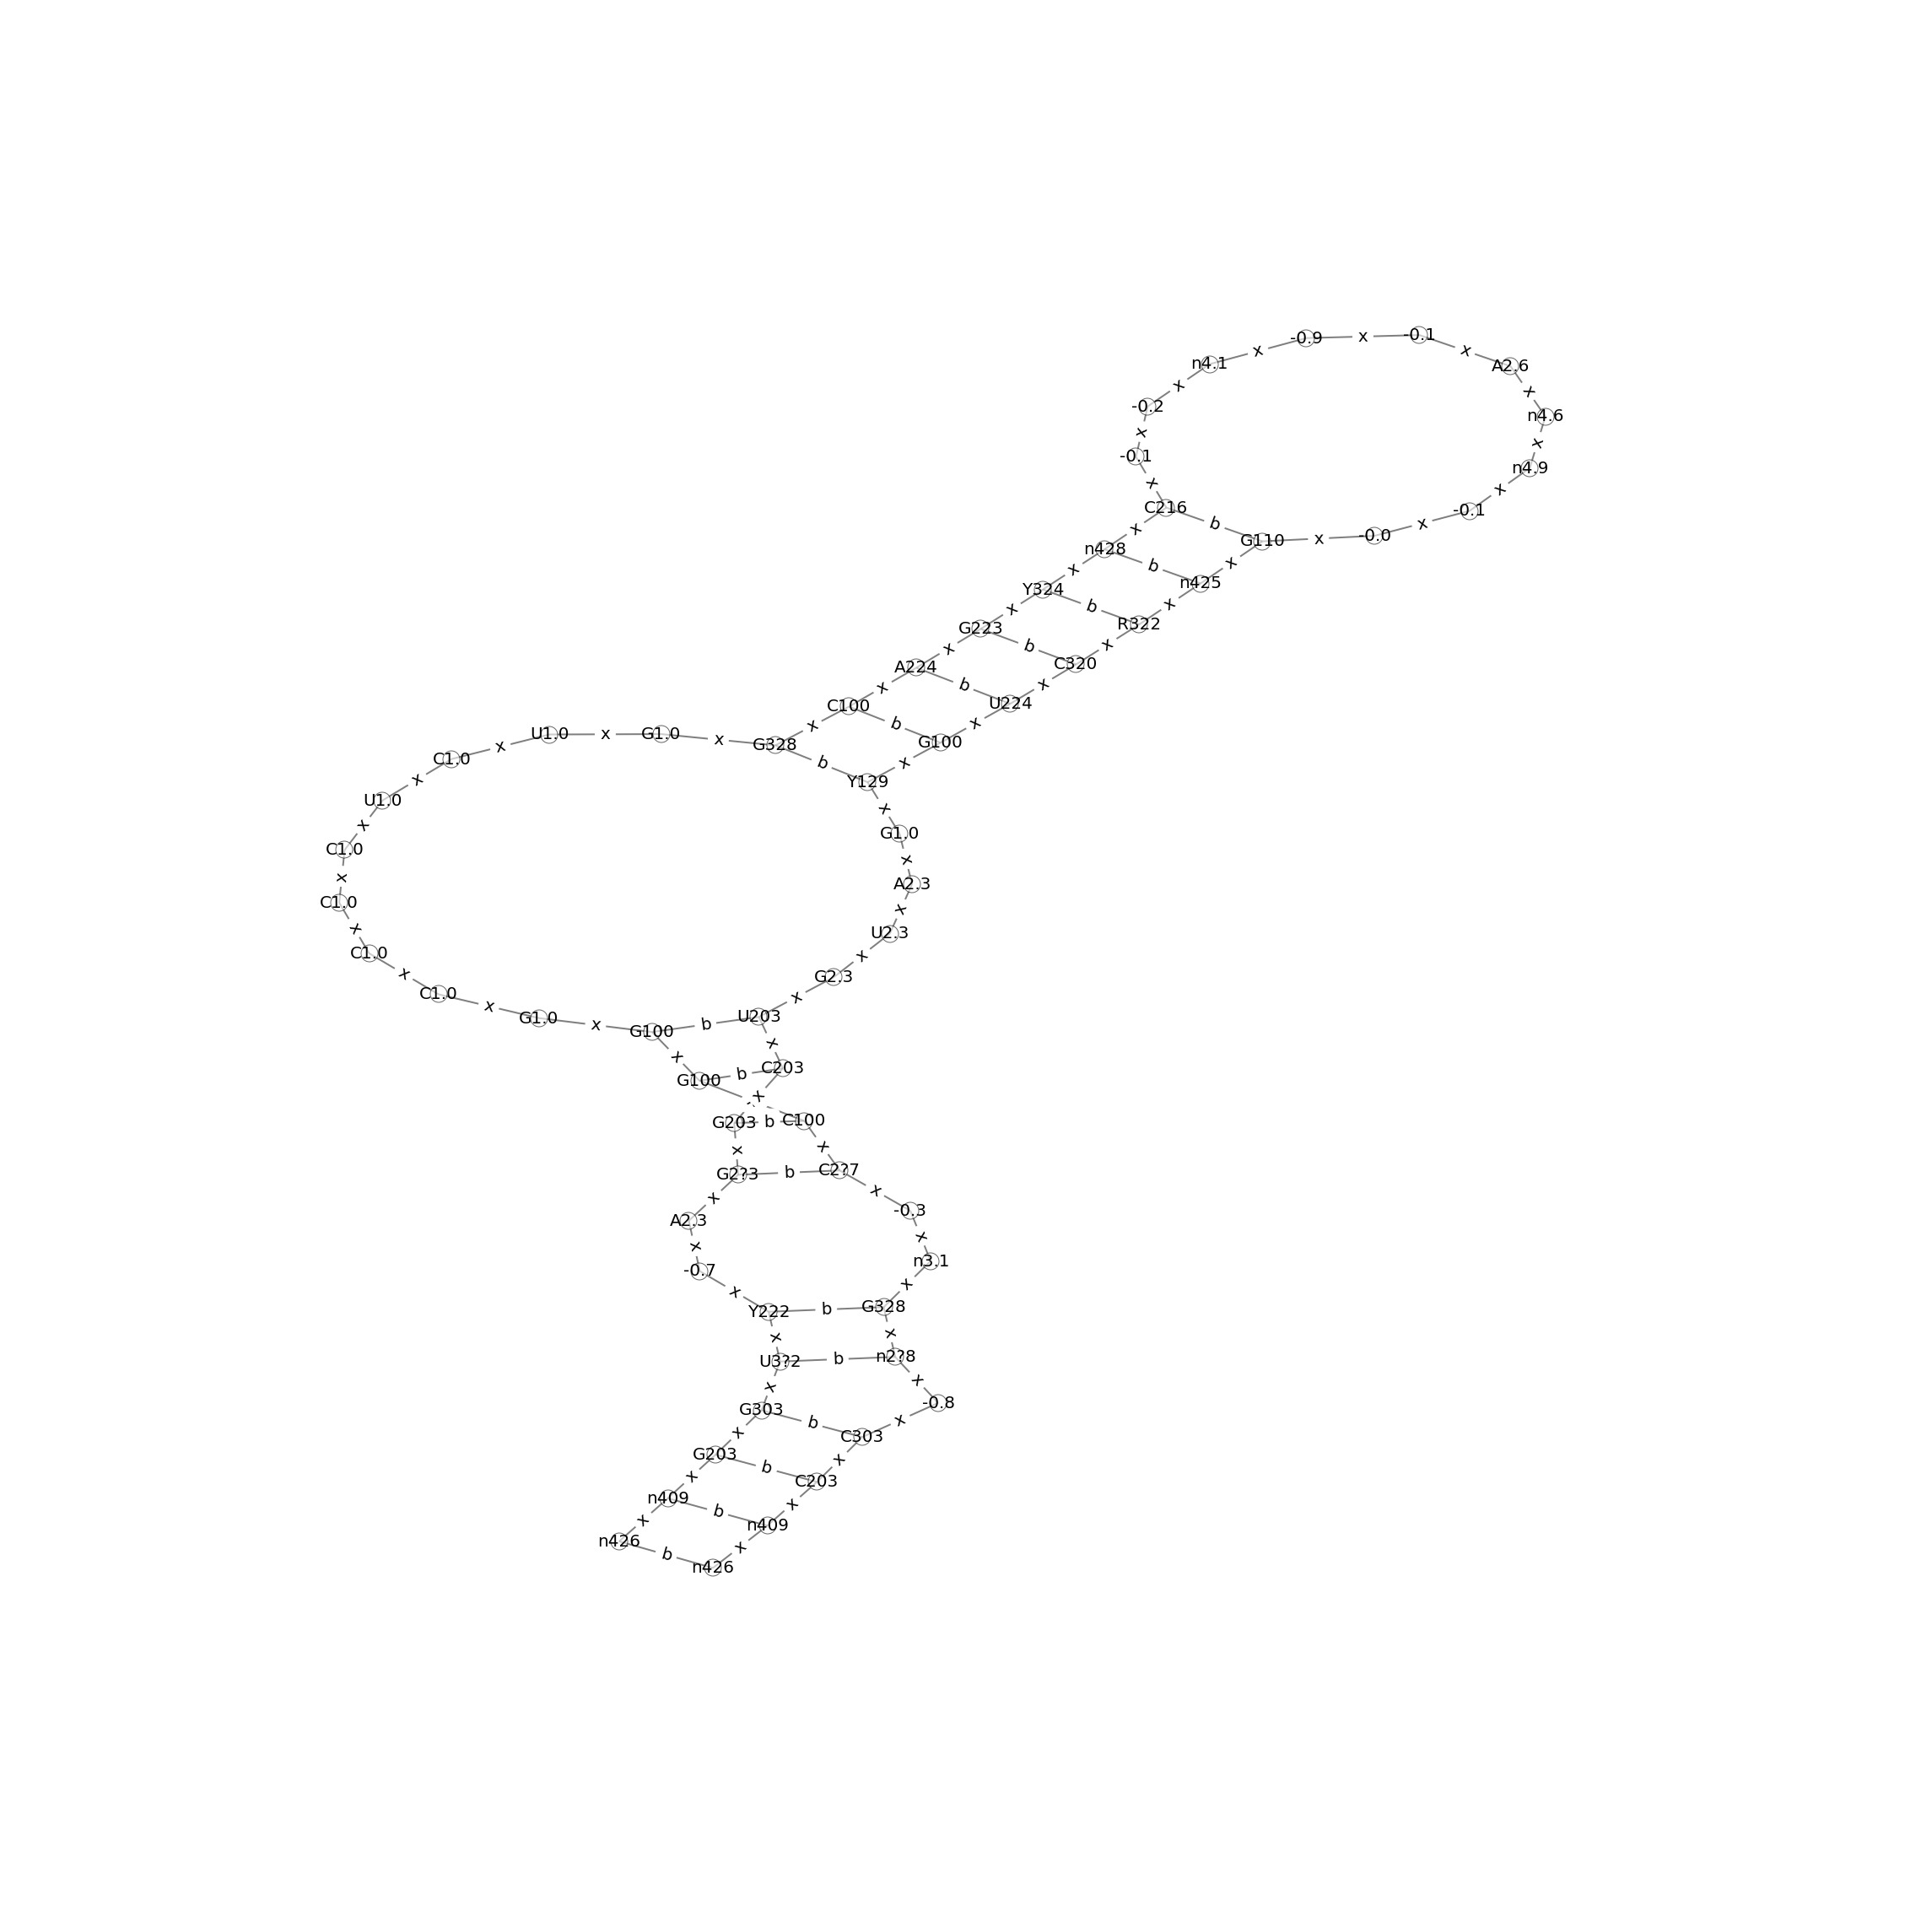

In [3]:
gremodel = gf.remodel(Graph, use_seq=True, use_cov = True, use_cor = True, use_ent = True)
display.draw_graph(Graph, size=40, node_size=400, font_size=20, node_border=True, prog='neato')

#### read a directory of '.sto' files and create their graphs

In [9]:
pos_class_0_path = "StoExamples/StoClasses/pos_class_0"
pos_class_1_path = "StoExamples/StoClasses/pos_class_1"
neg_class_0_path = "StoExamples/StoClasses/neg_class_0"
neg_class_1_path = "StoExamples/StoClasses/neg_class_1"

pos_class_0_abs_path = os.path.abspath(pos_class_0_path)
pos_class_1_abs_path = os.path.abspath(pos_class_1_path)
neg_class_0_abs_path = os.path.abspath(neg_class_0_path)
neg_class_1_abs_path = os.path.abspath(neg_class_1_path)

convert files to graphs

In [10]:
gf = GraphFinder()
pos_0_Graphs = gf.folder_to_graph_convertor(pos_class_0_abs_path)
pos_1_Graphs = gf.folder_to_graph_convertor(pos_class_1_abs_path)
neg_0_Graphs = gf.folder_to_graph_convertor(neg_class_0_abs_path)
neg_1_Graphs = gf.folder_to_graph_convertor(neg_class_1_abs_path)

remodel the created graphs based on the desired info type

In [11]:
for graph in pos_0_Graphs:
    remodel_pos_0_Graphs = gf.remodel(graph, use_seq=True, use_cov = False)
for graph in pos_1_Graphs:
    remodel_pos_1_Graphs = gf.remodel(graph, use_seq=True, use_cov = False)
for graph in neg_0_Graphs:
    remodel_neg_0_Graphs = gf.remodel(graph, use_seq=True, use_cov = False)
for graph in neg_1_Graphs:
    remodel_neg_1_Graphs = gf.remodel(graph, use_seq=True, use_cov = False)

draw the remodeled graphs

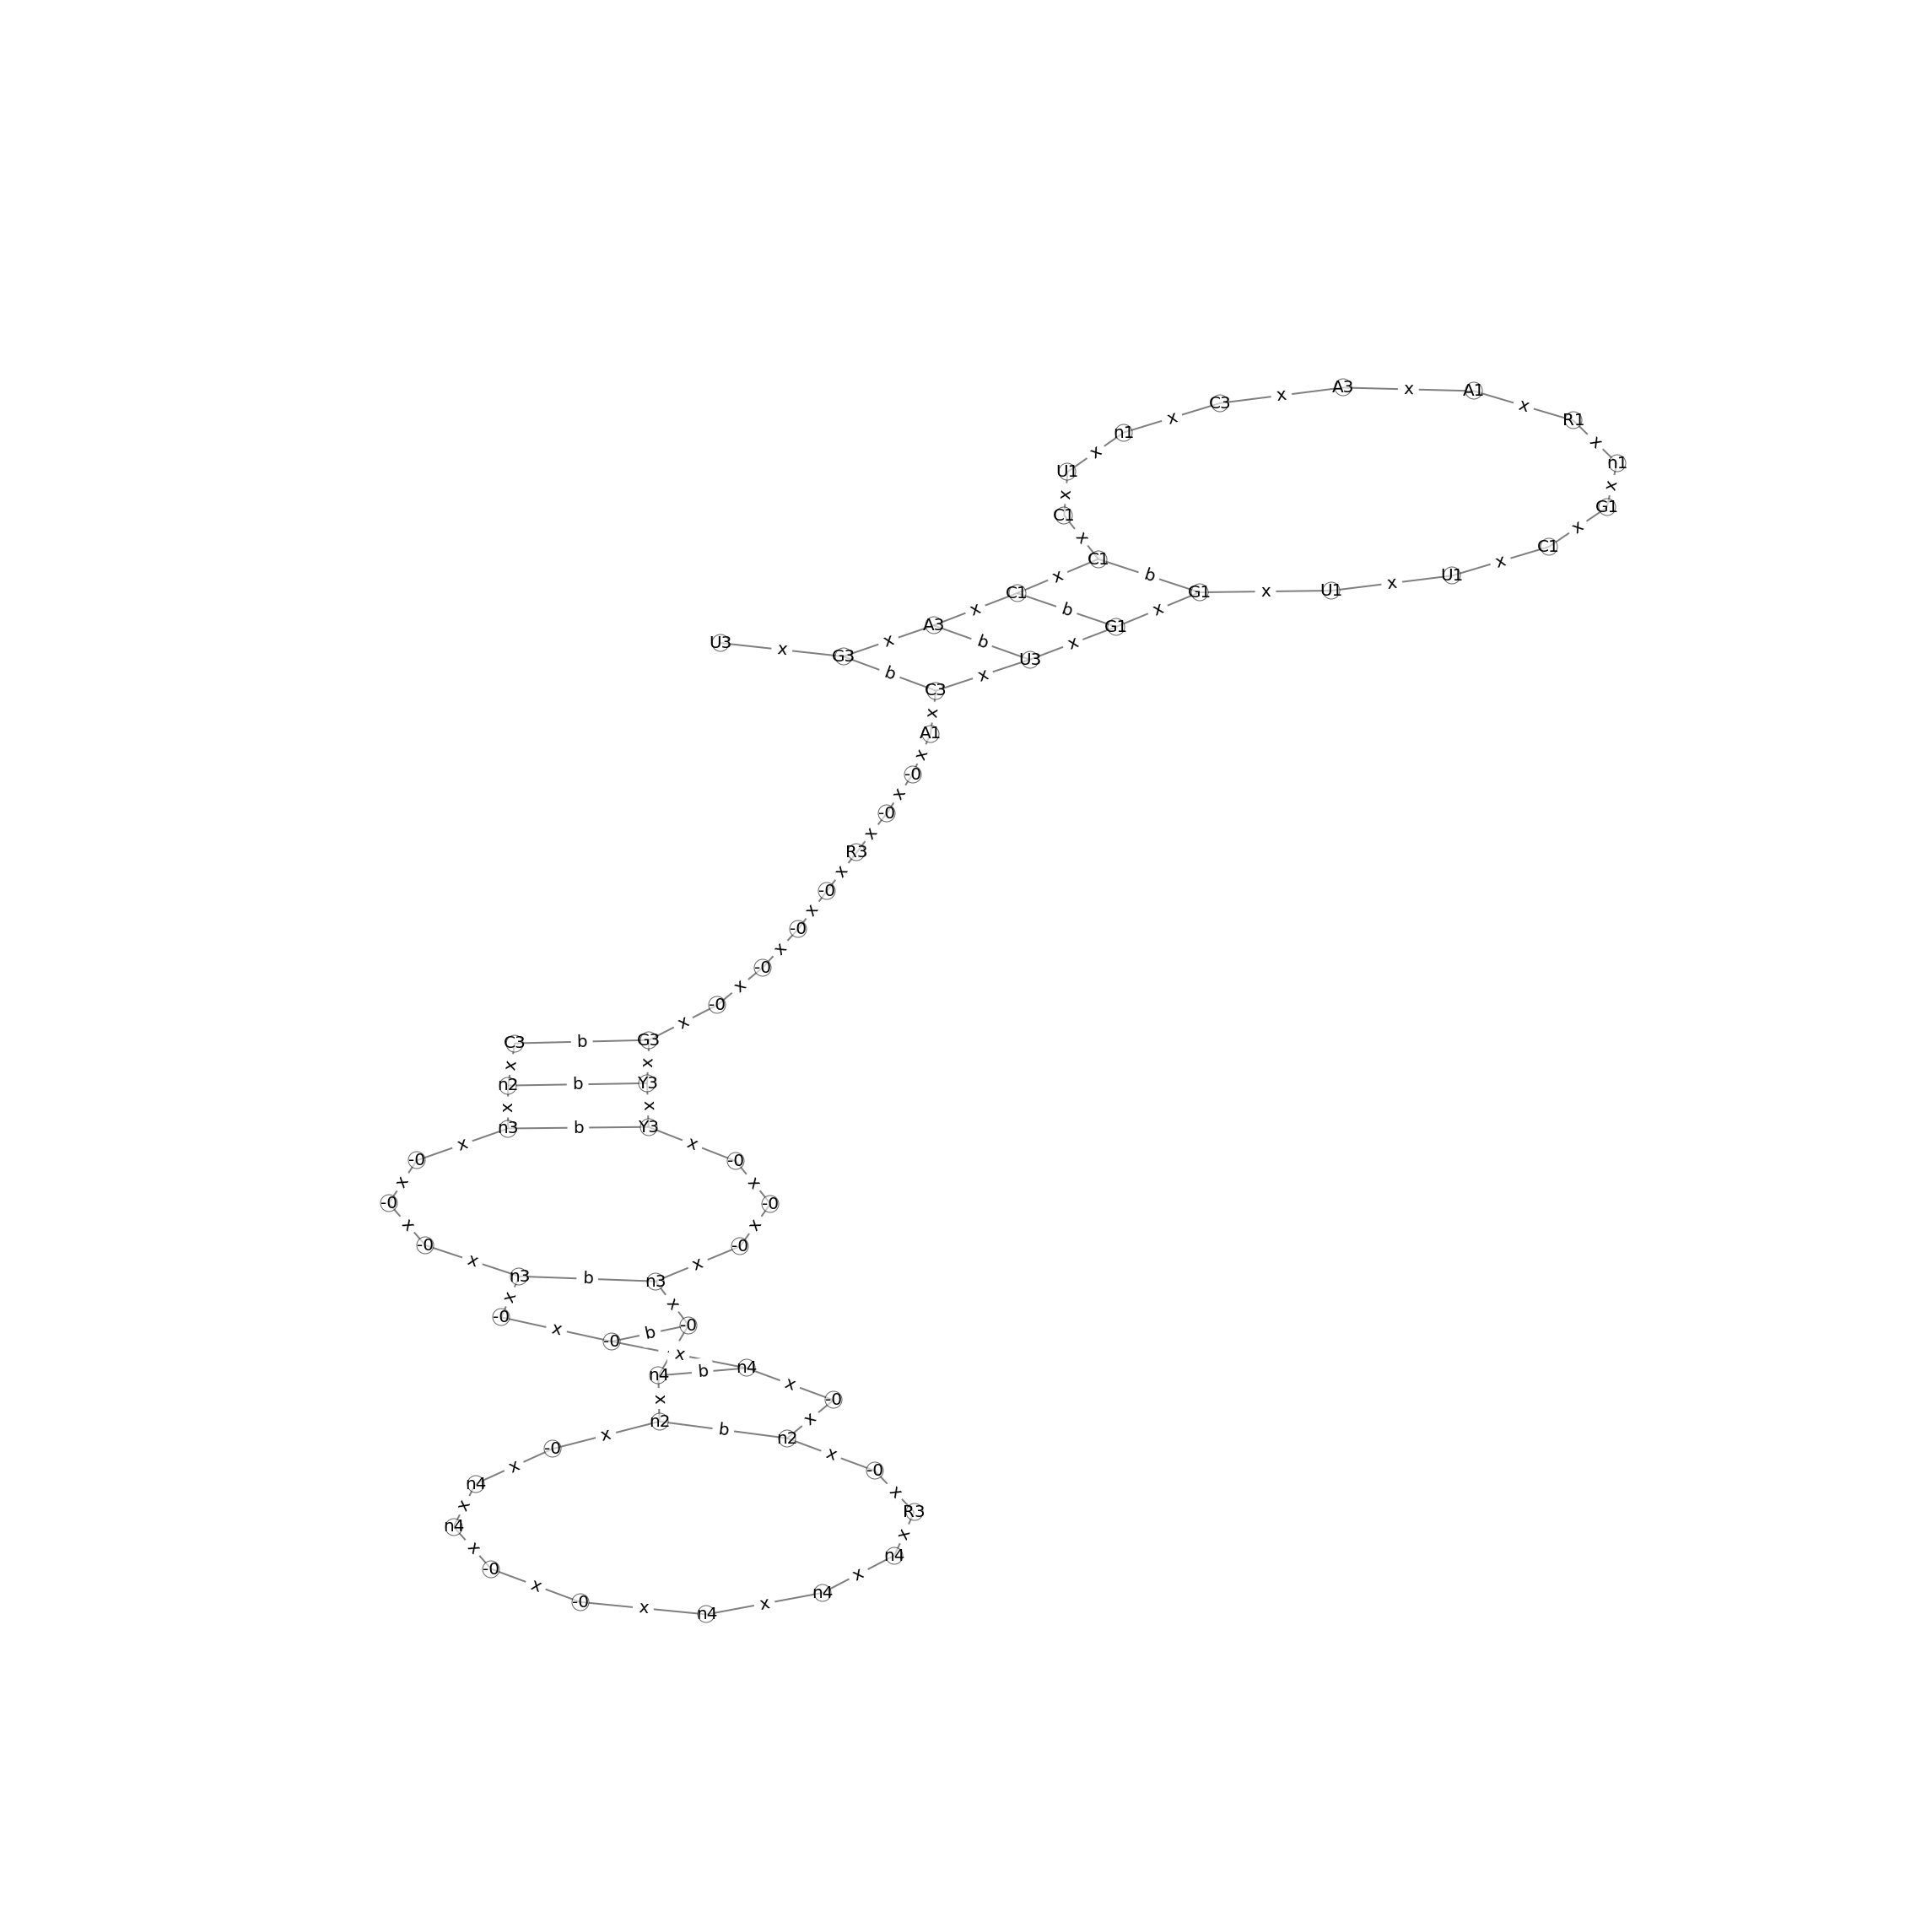

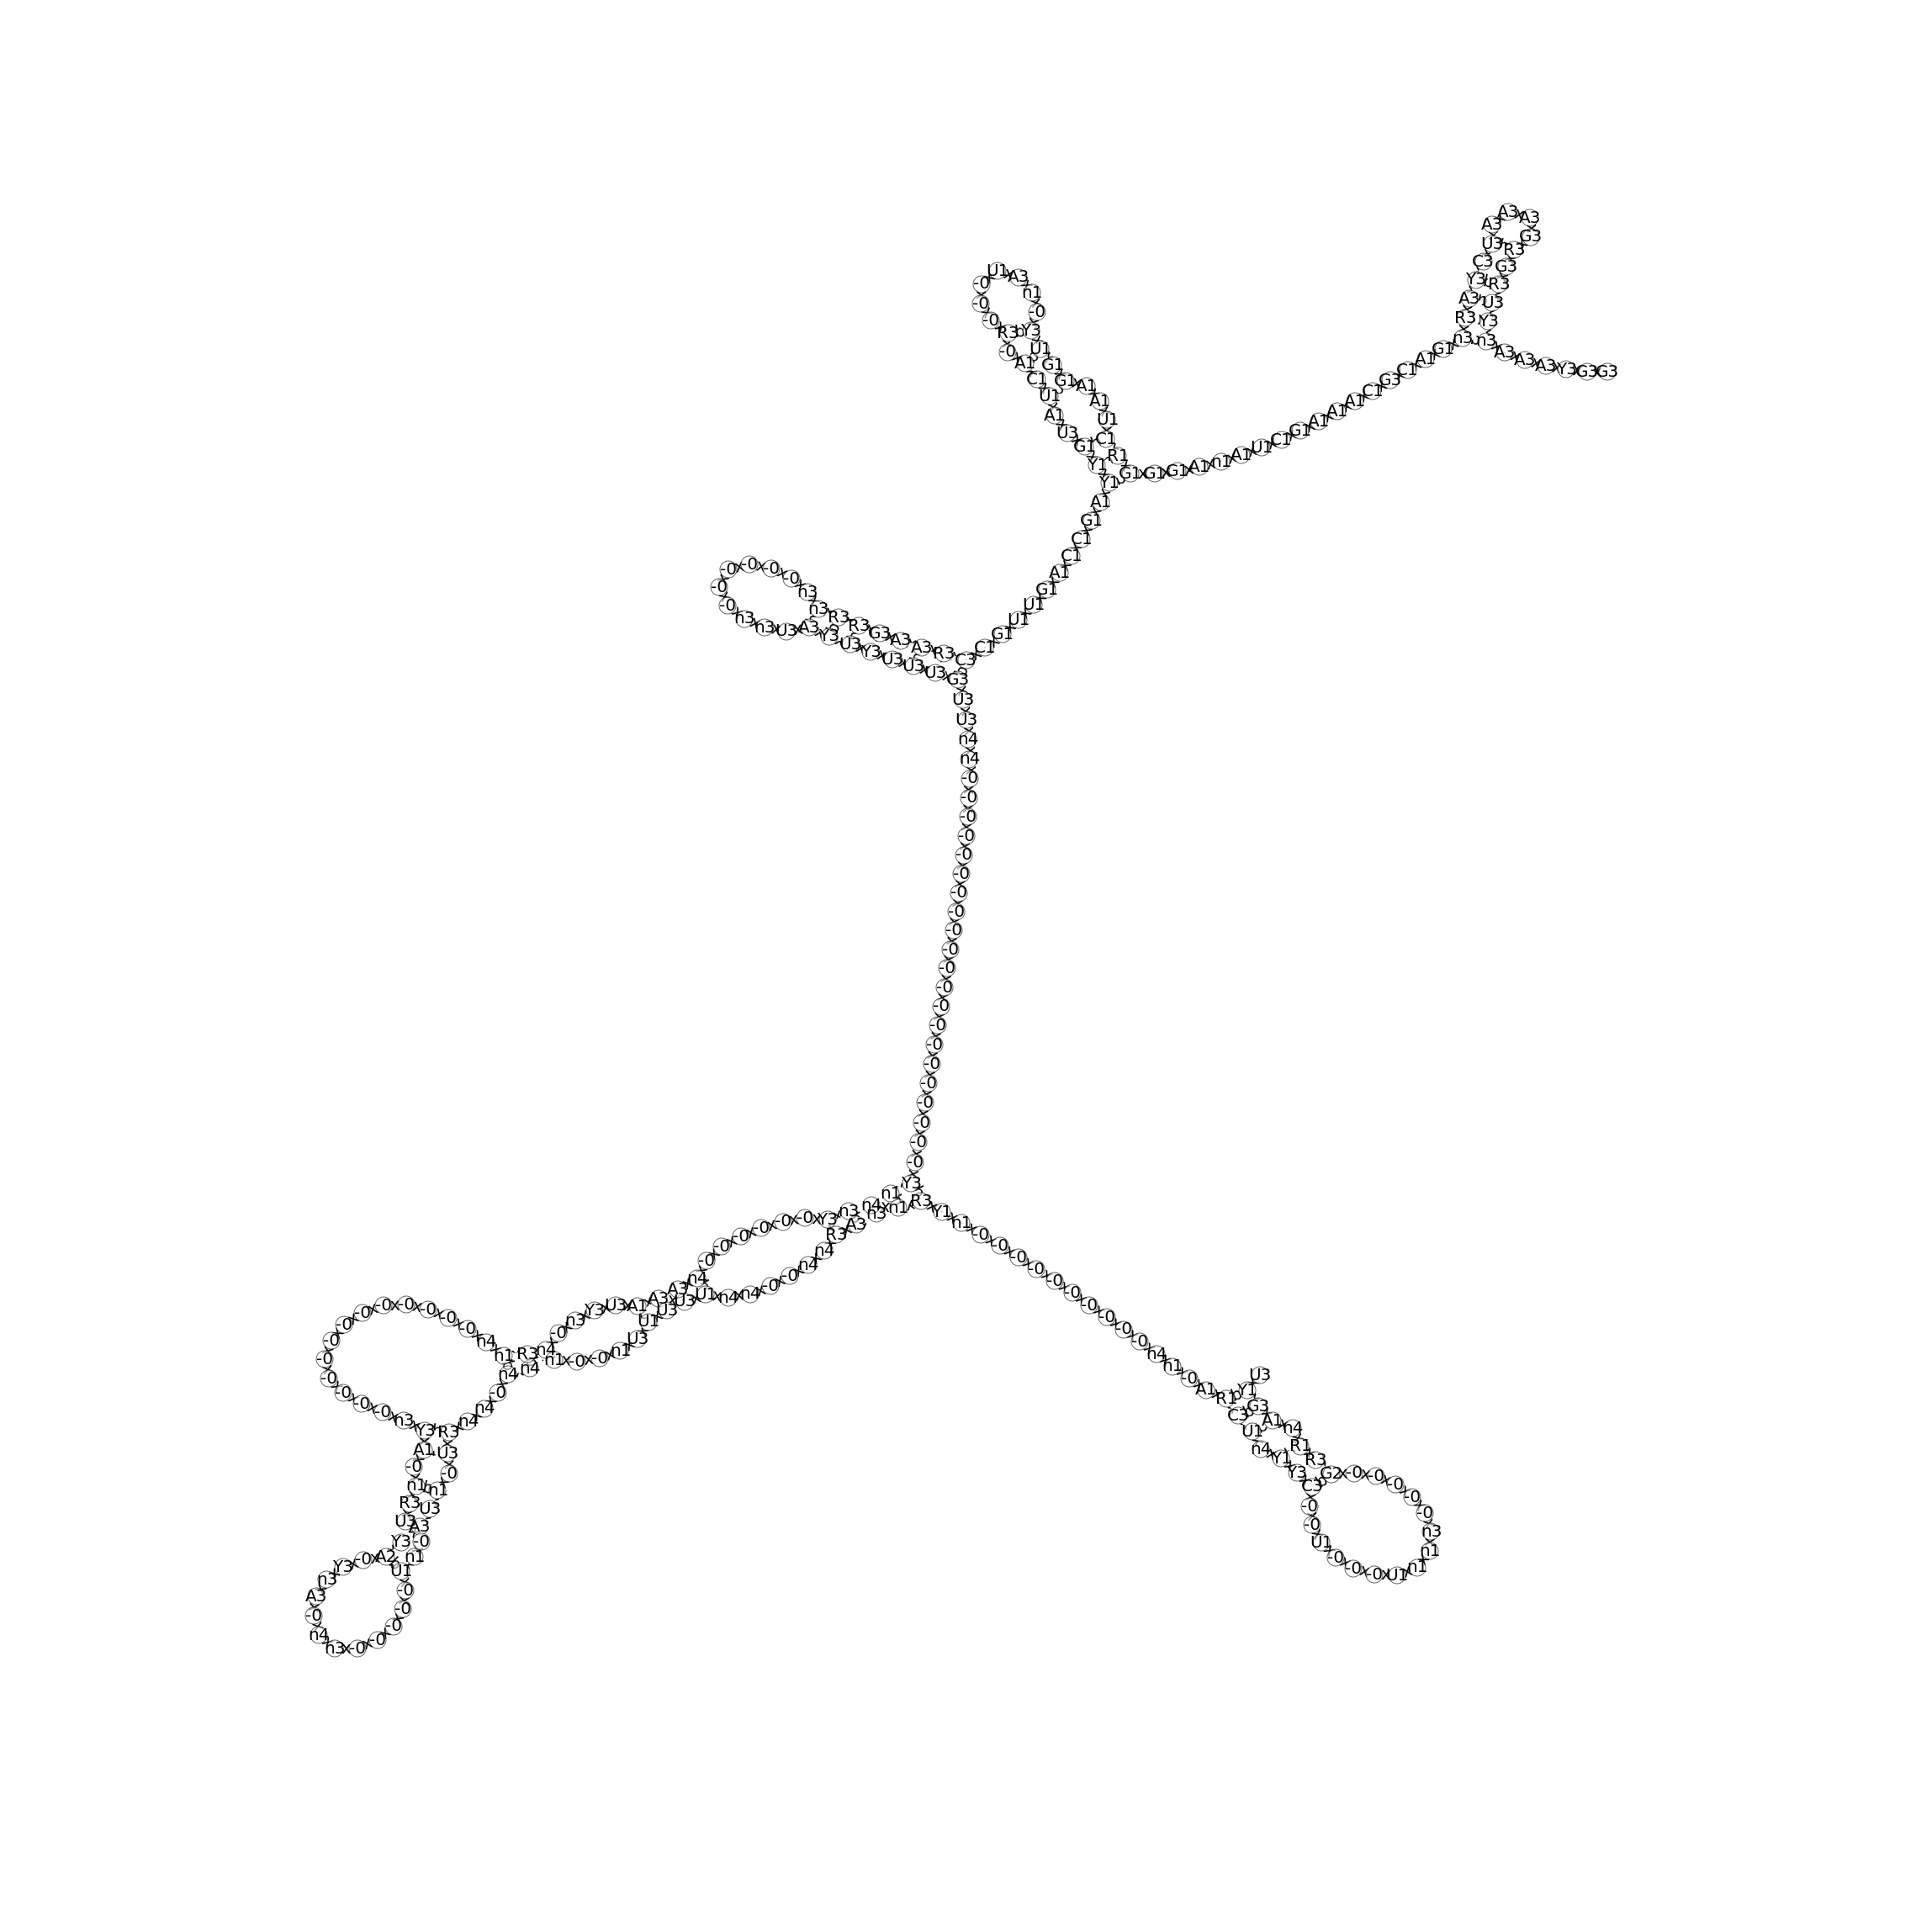

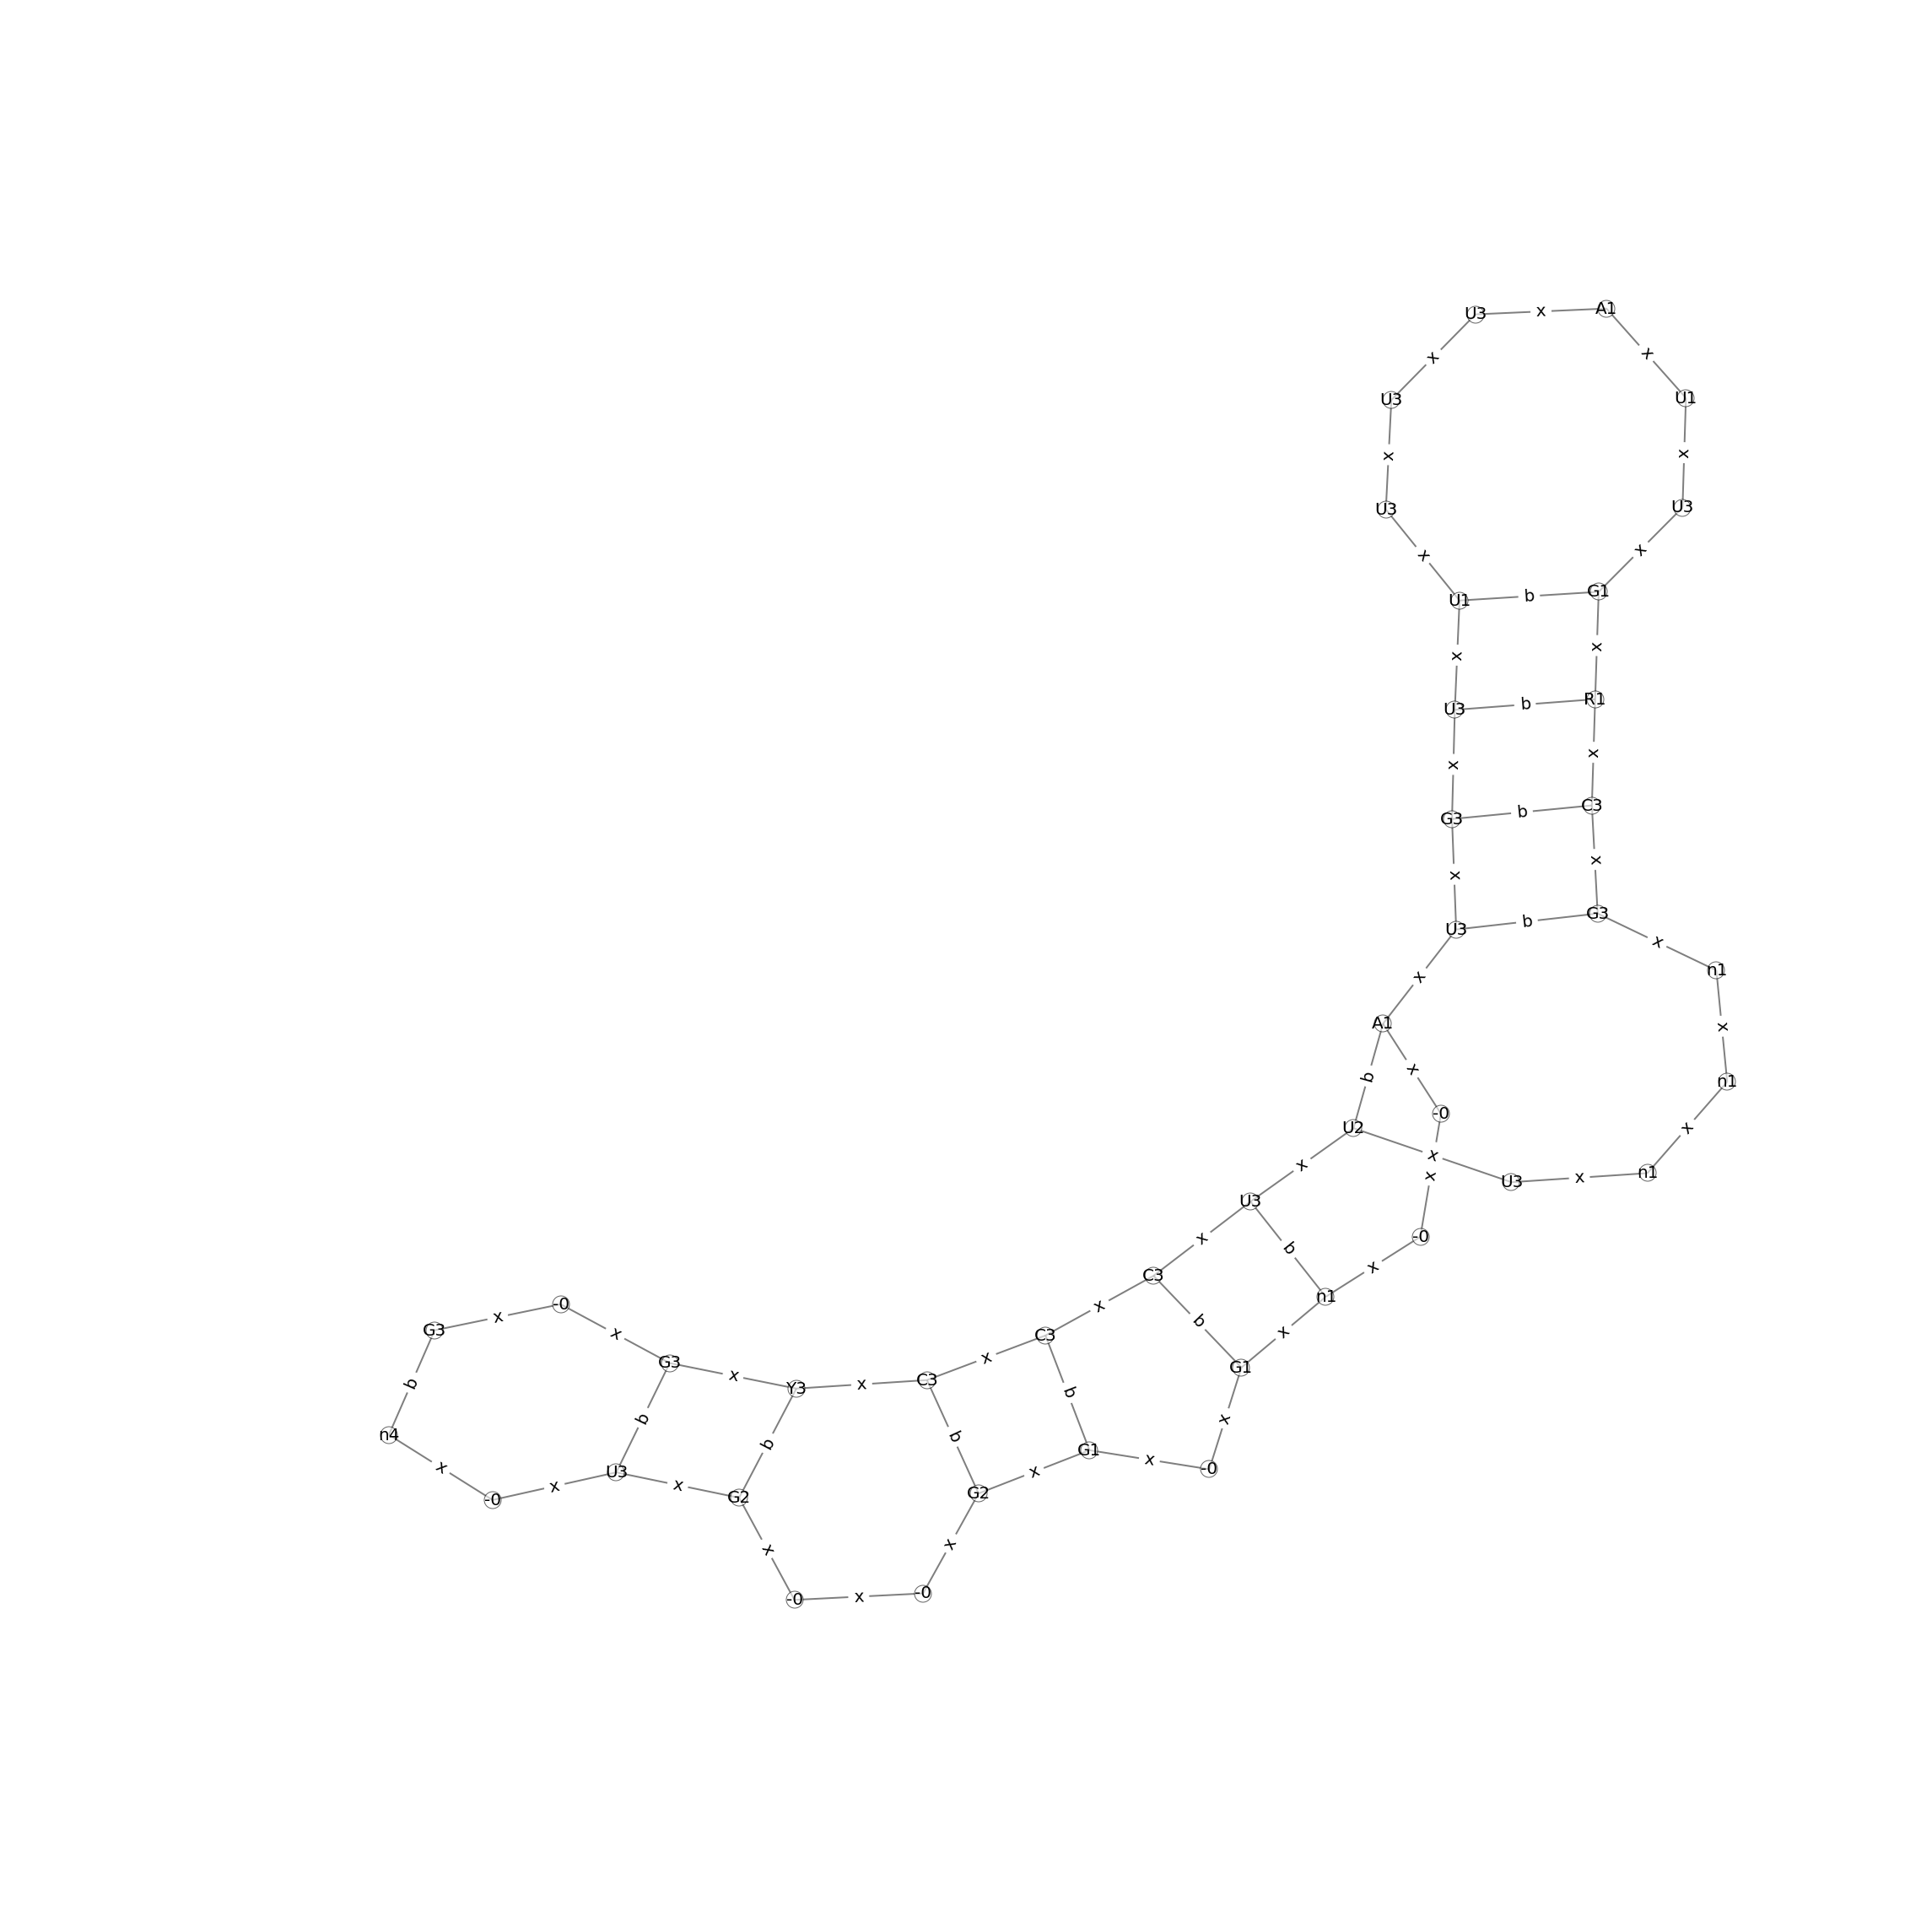

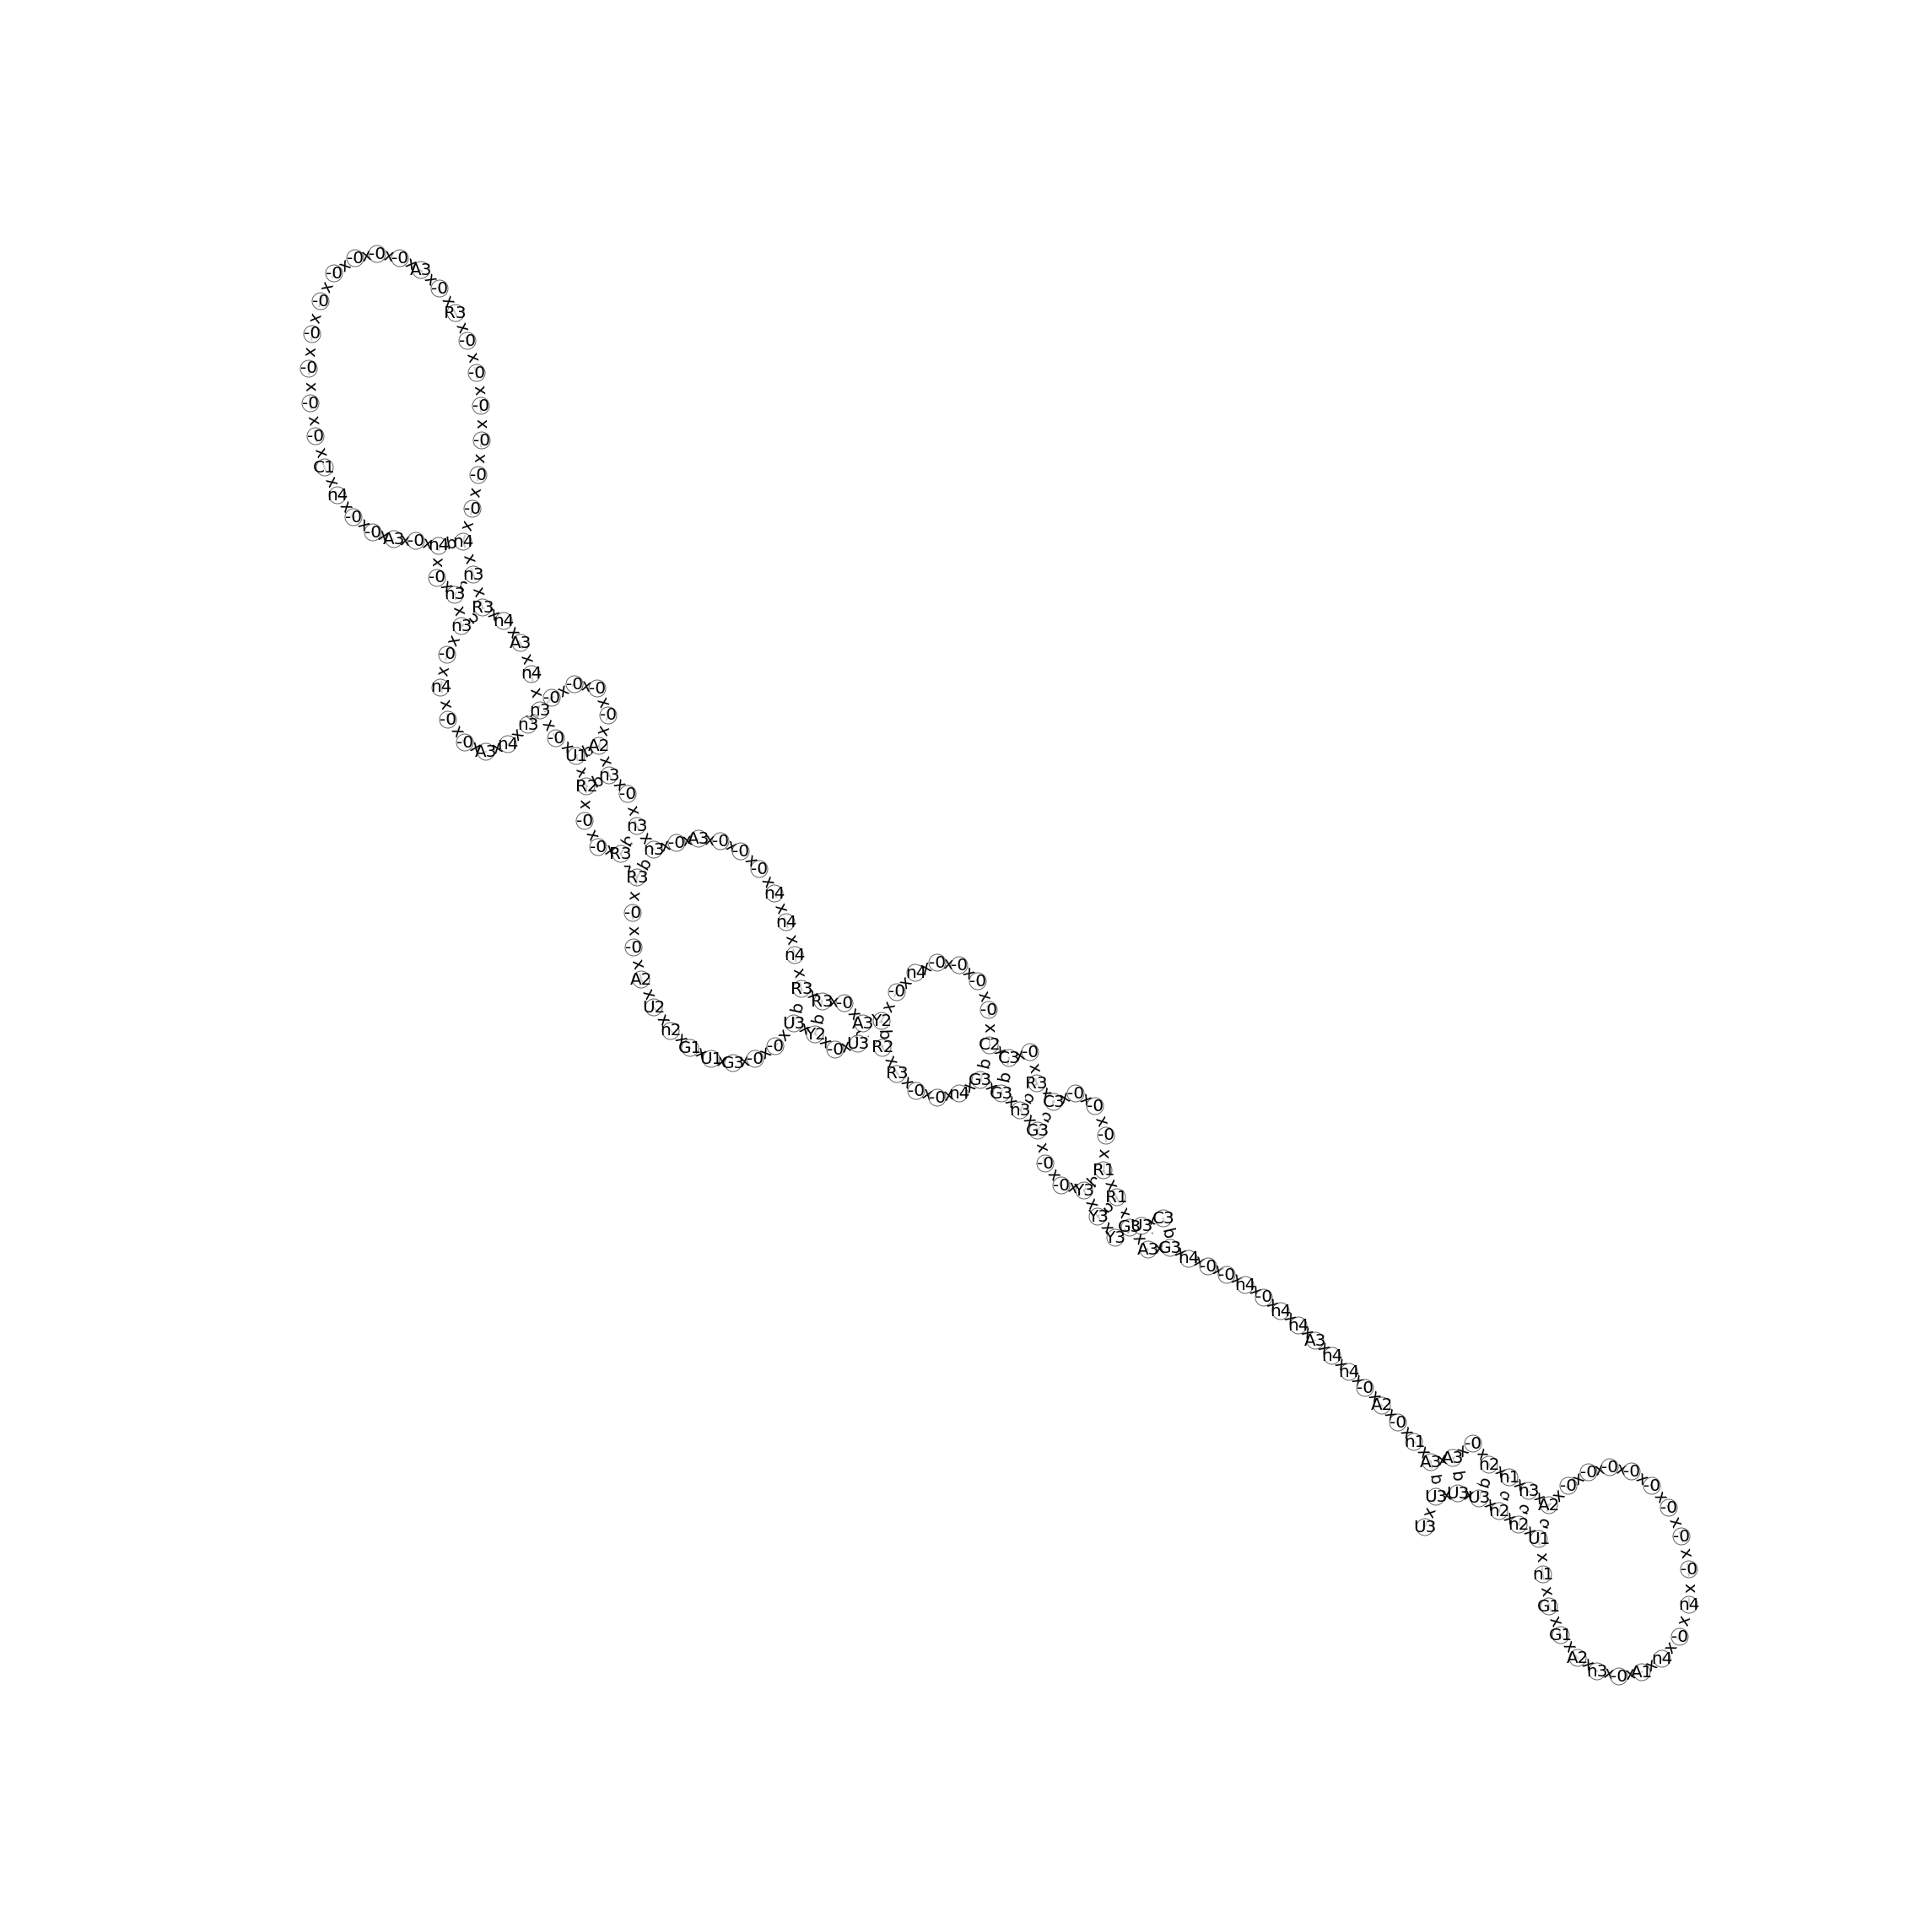

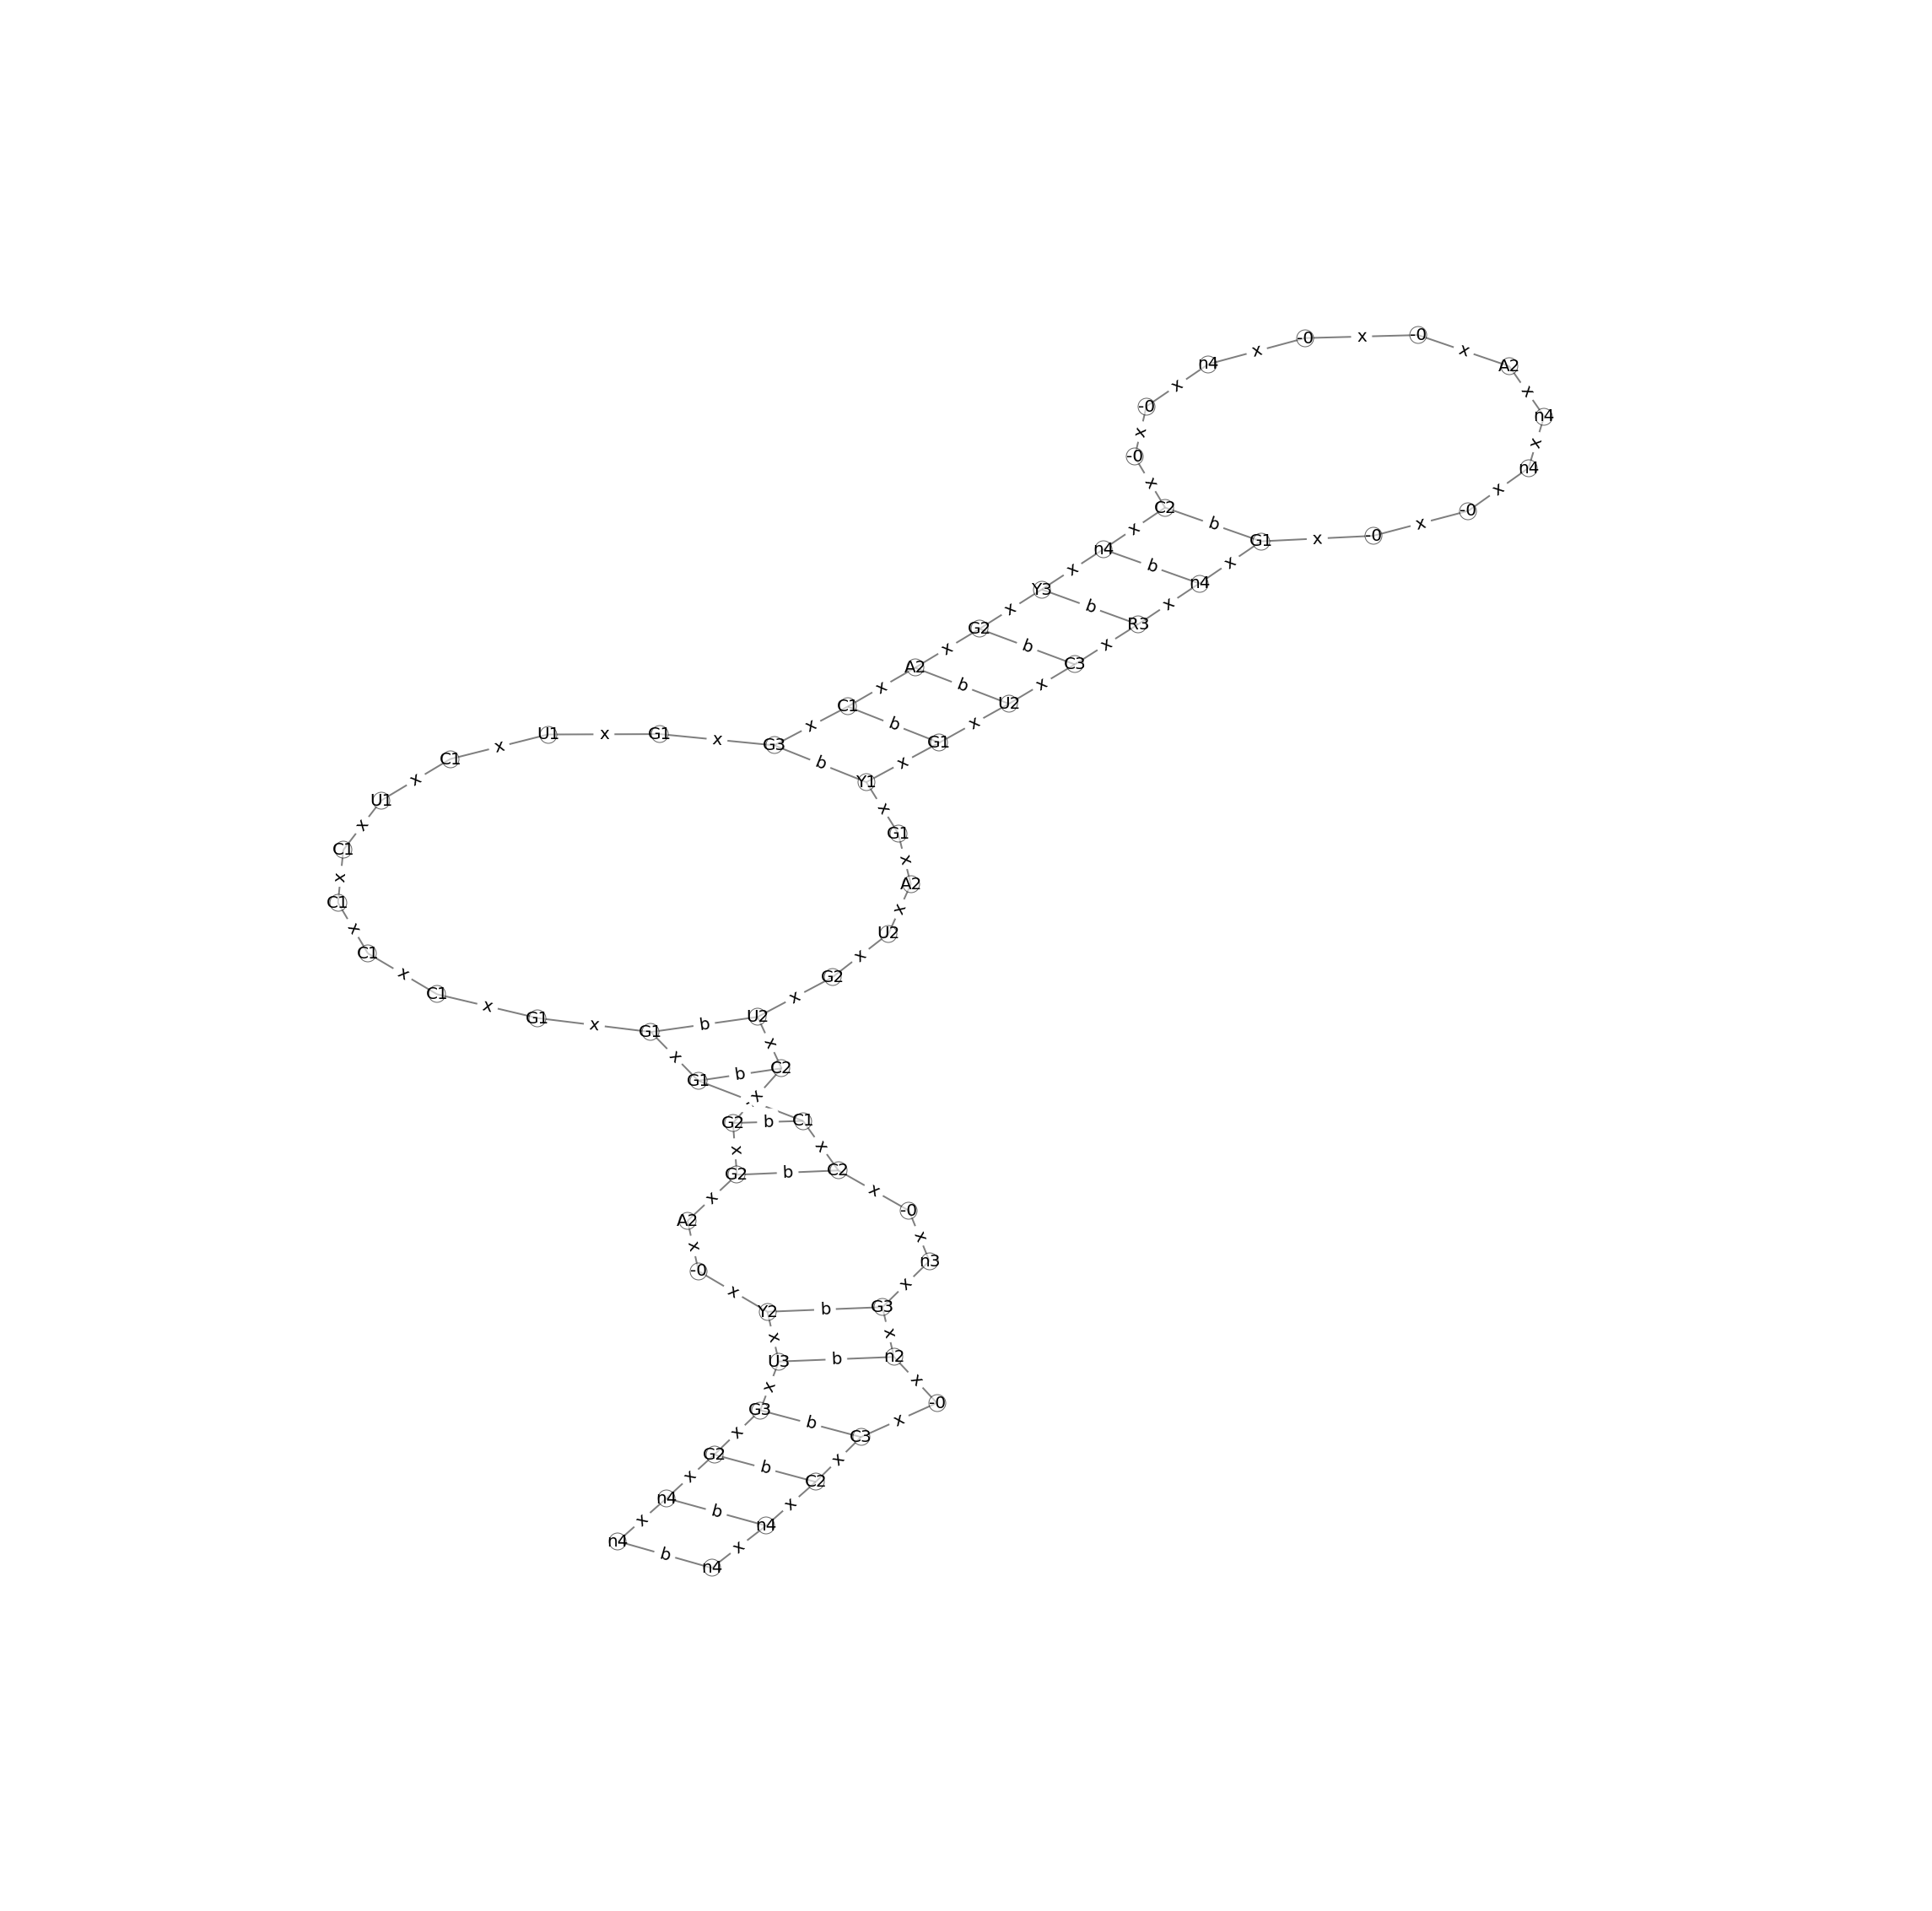

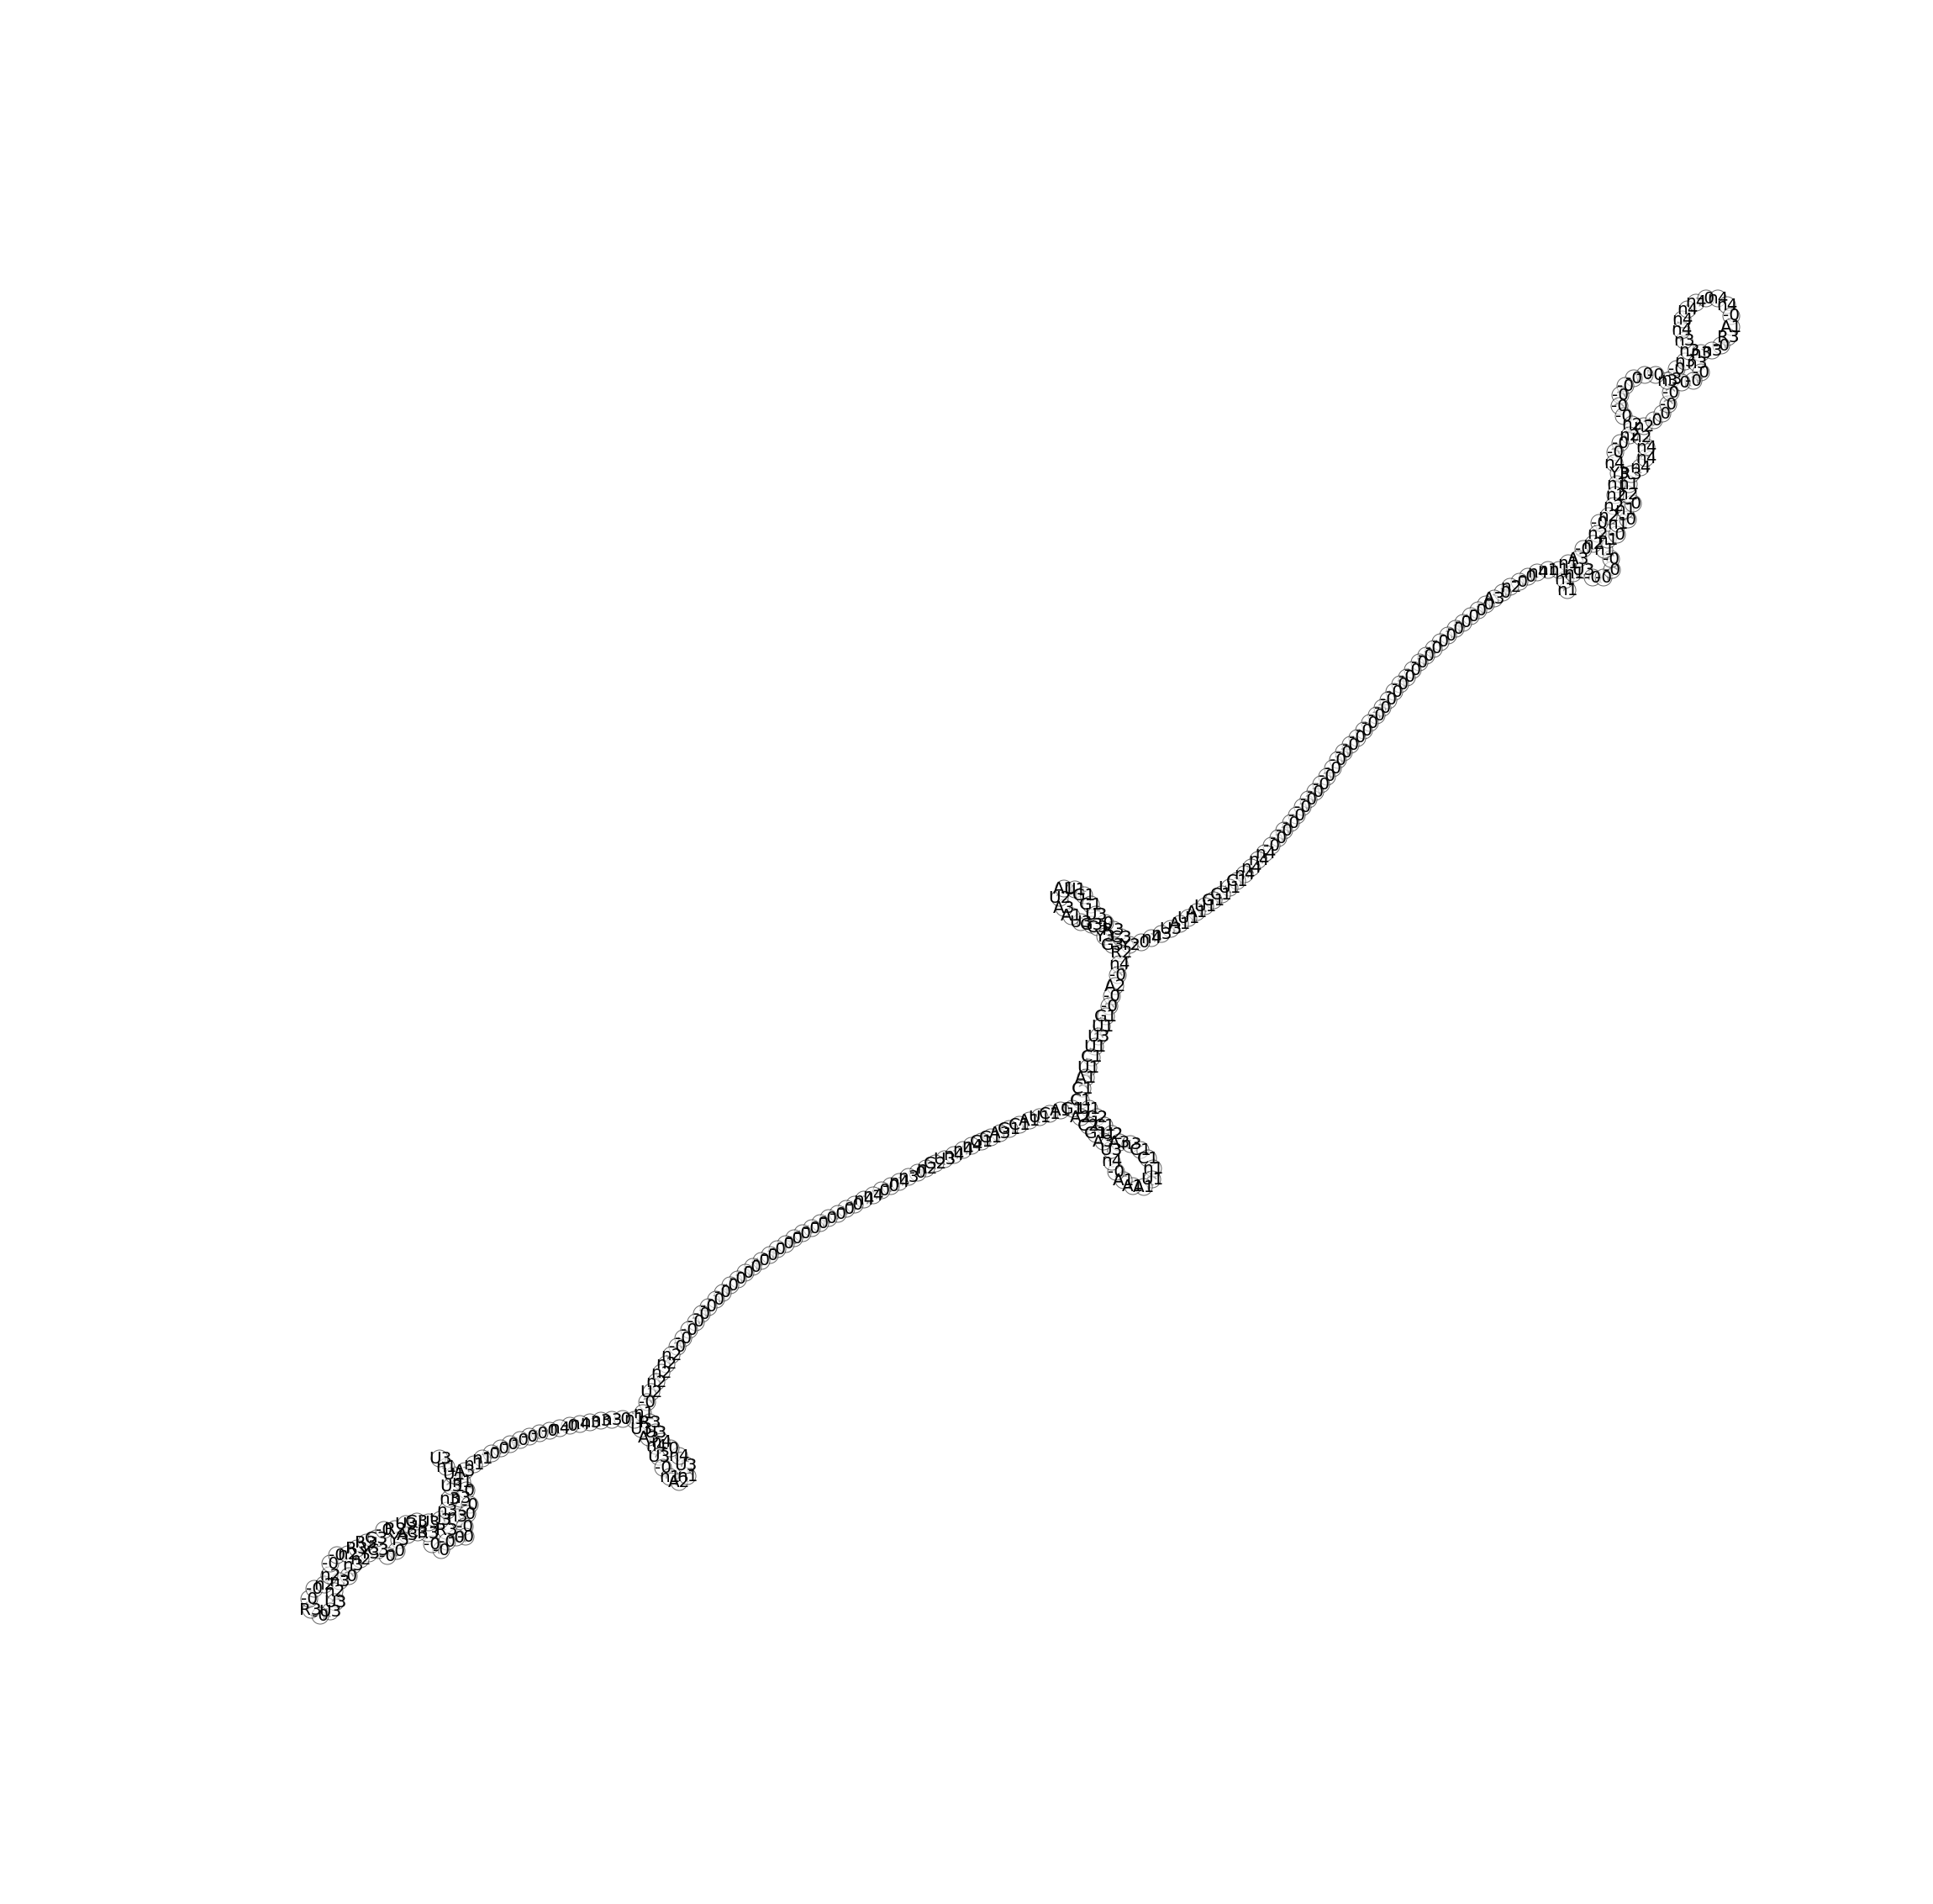

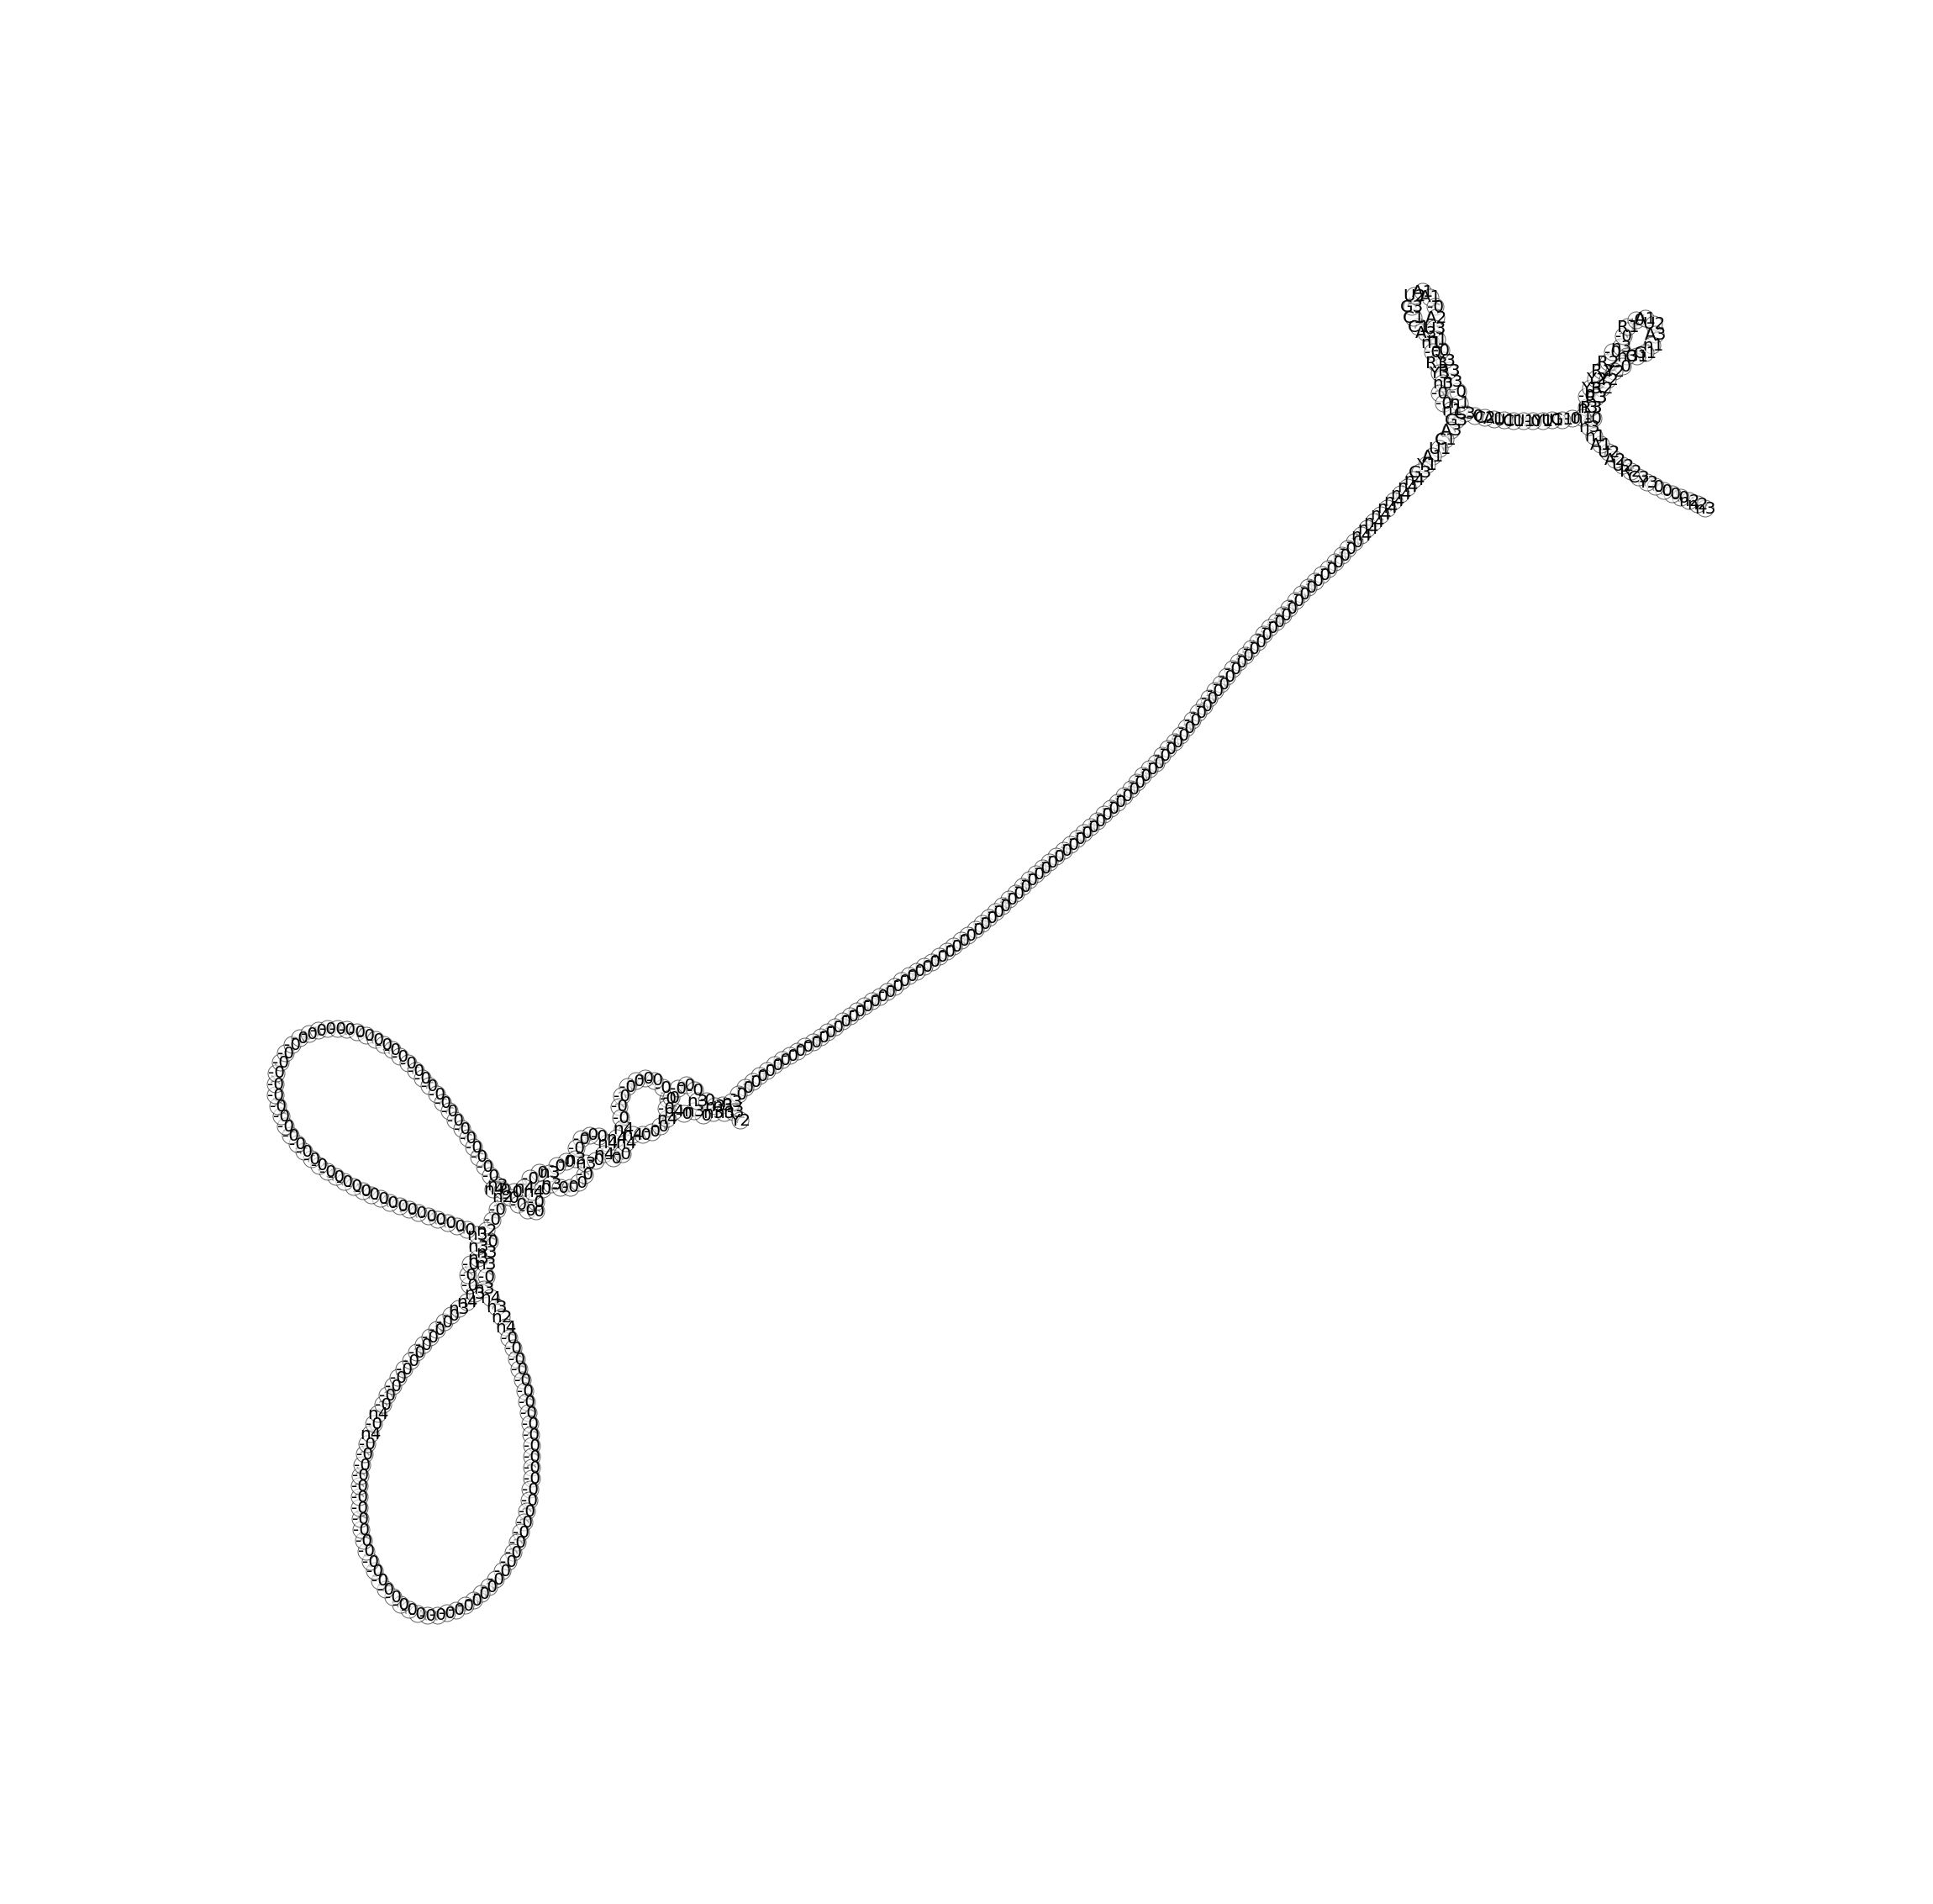

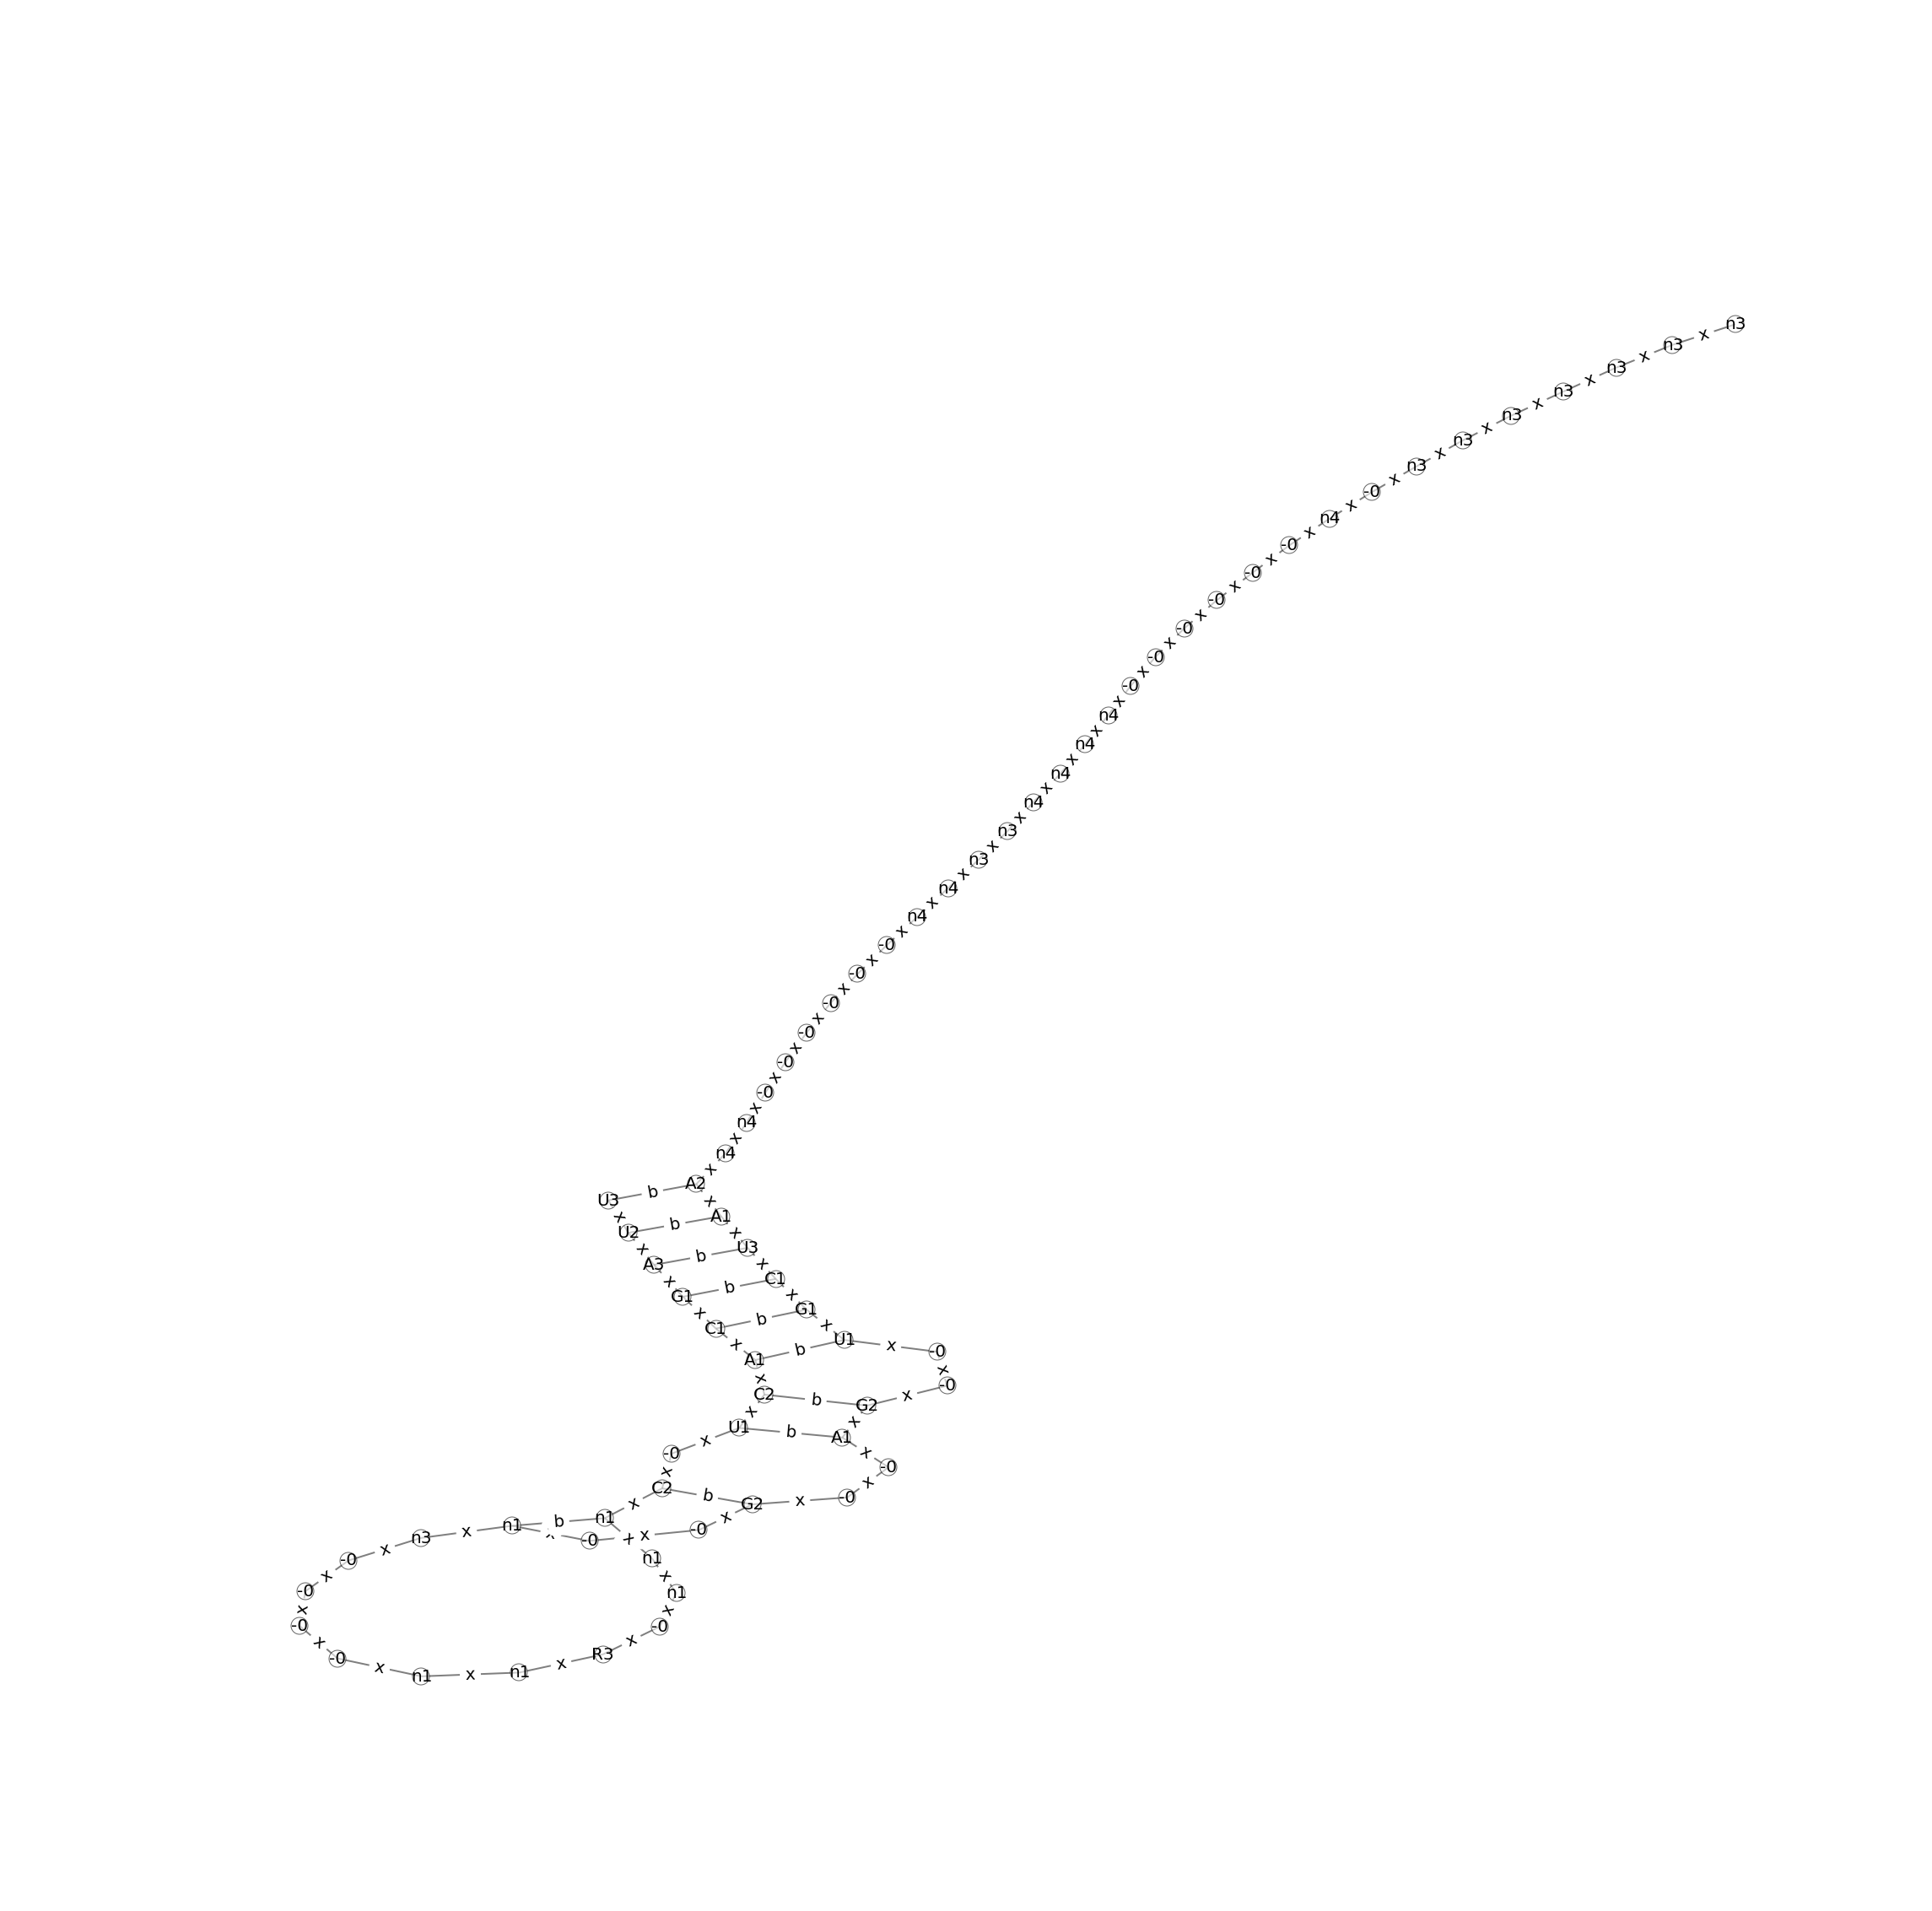

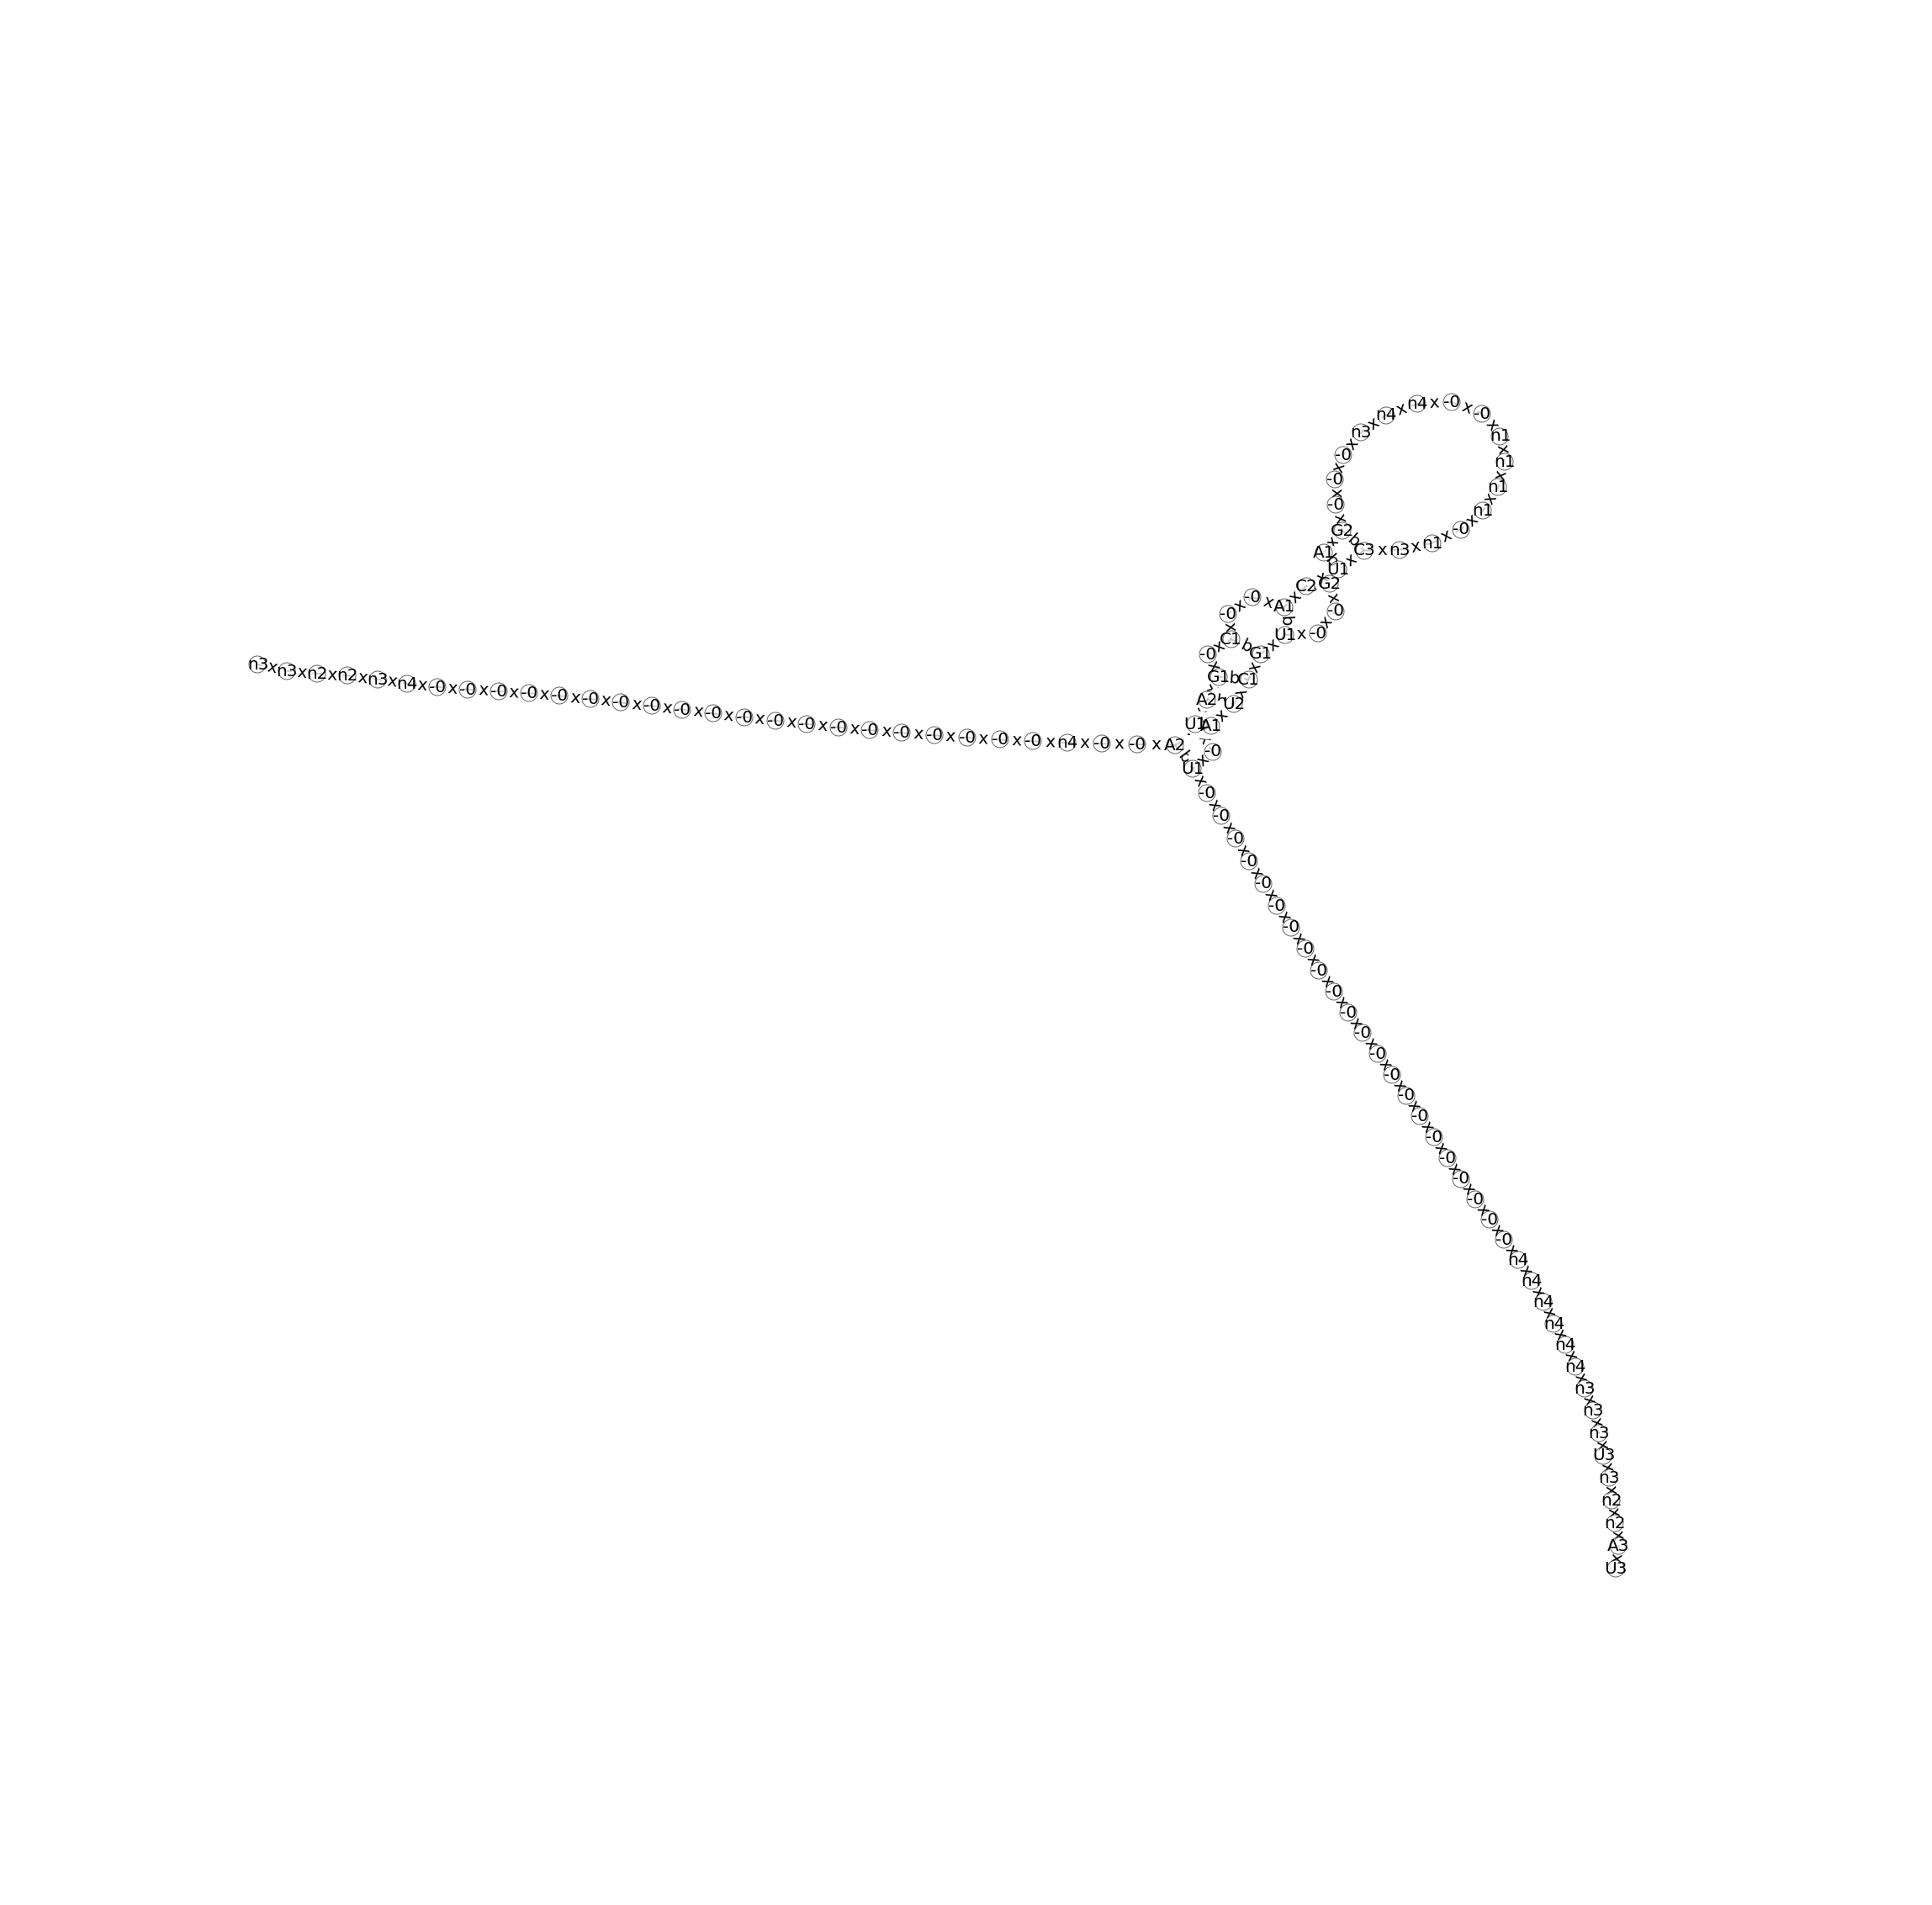

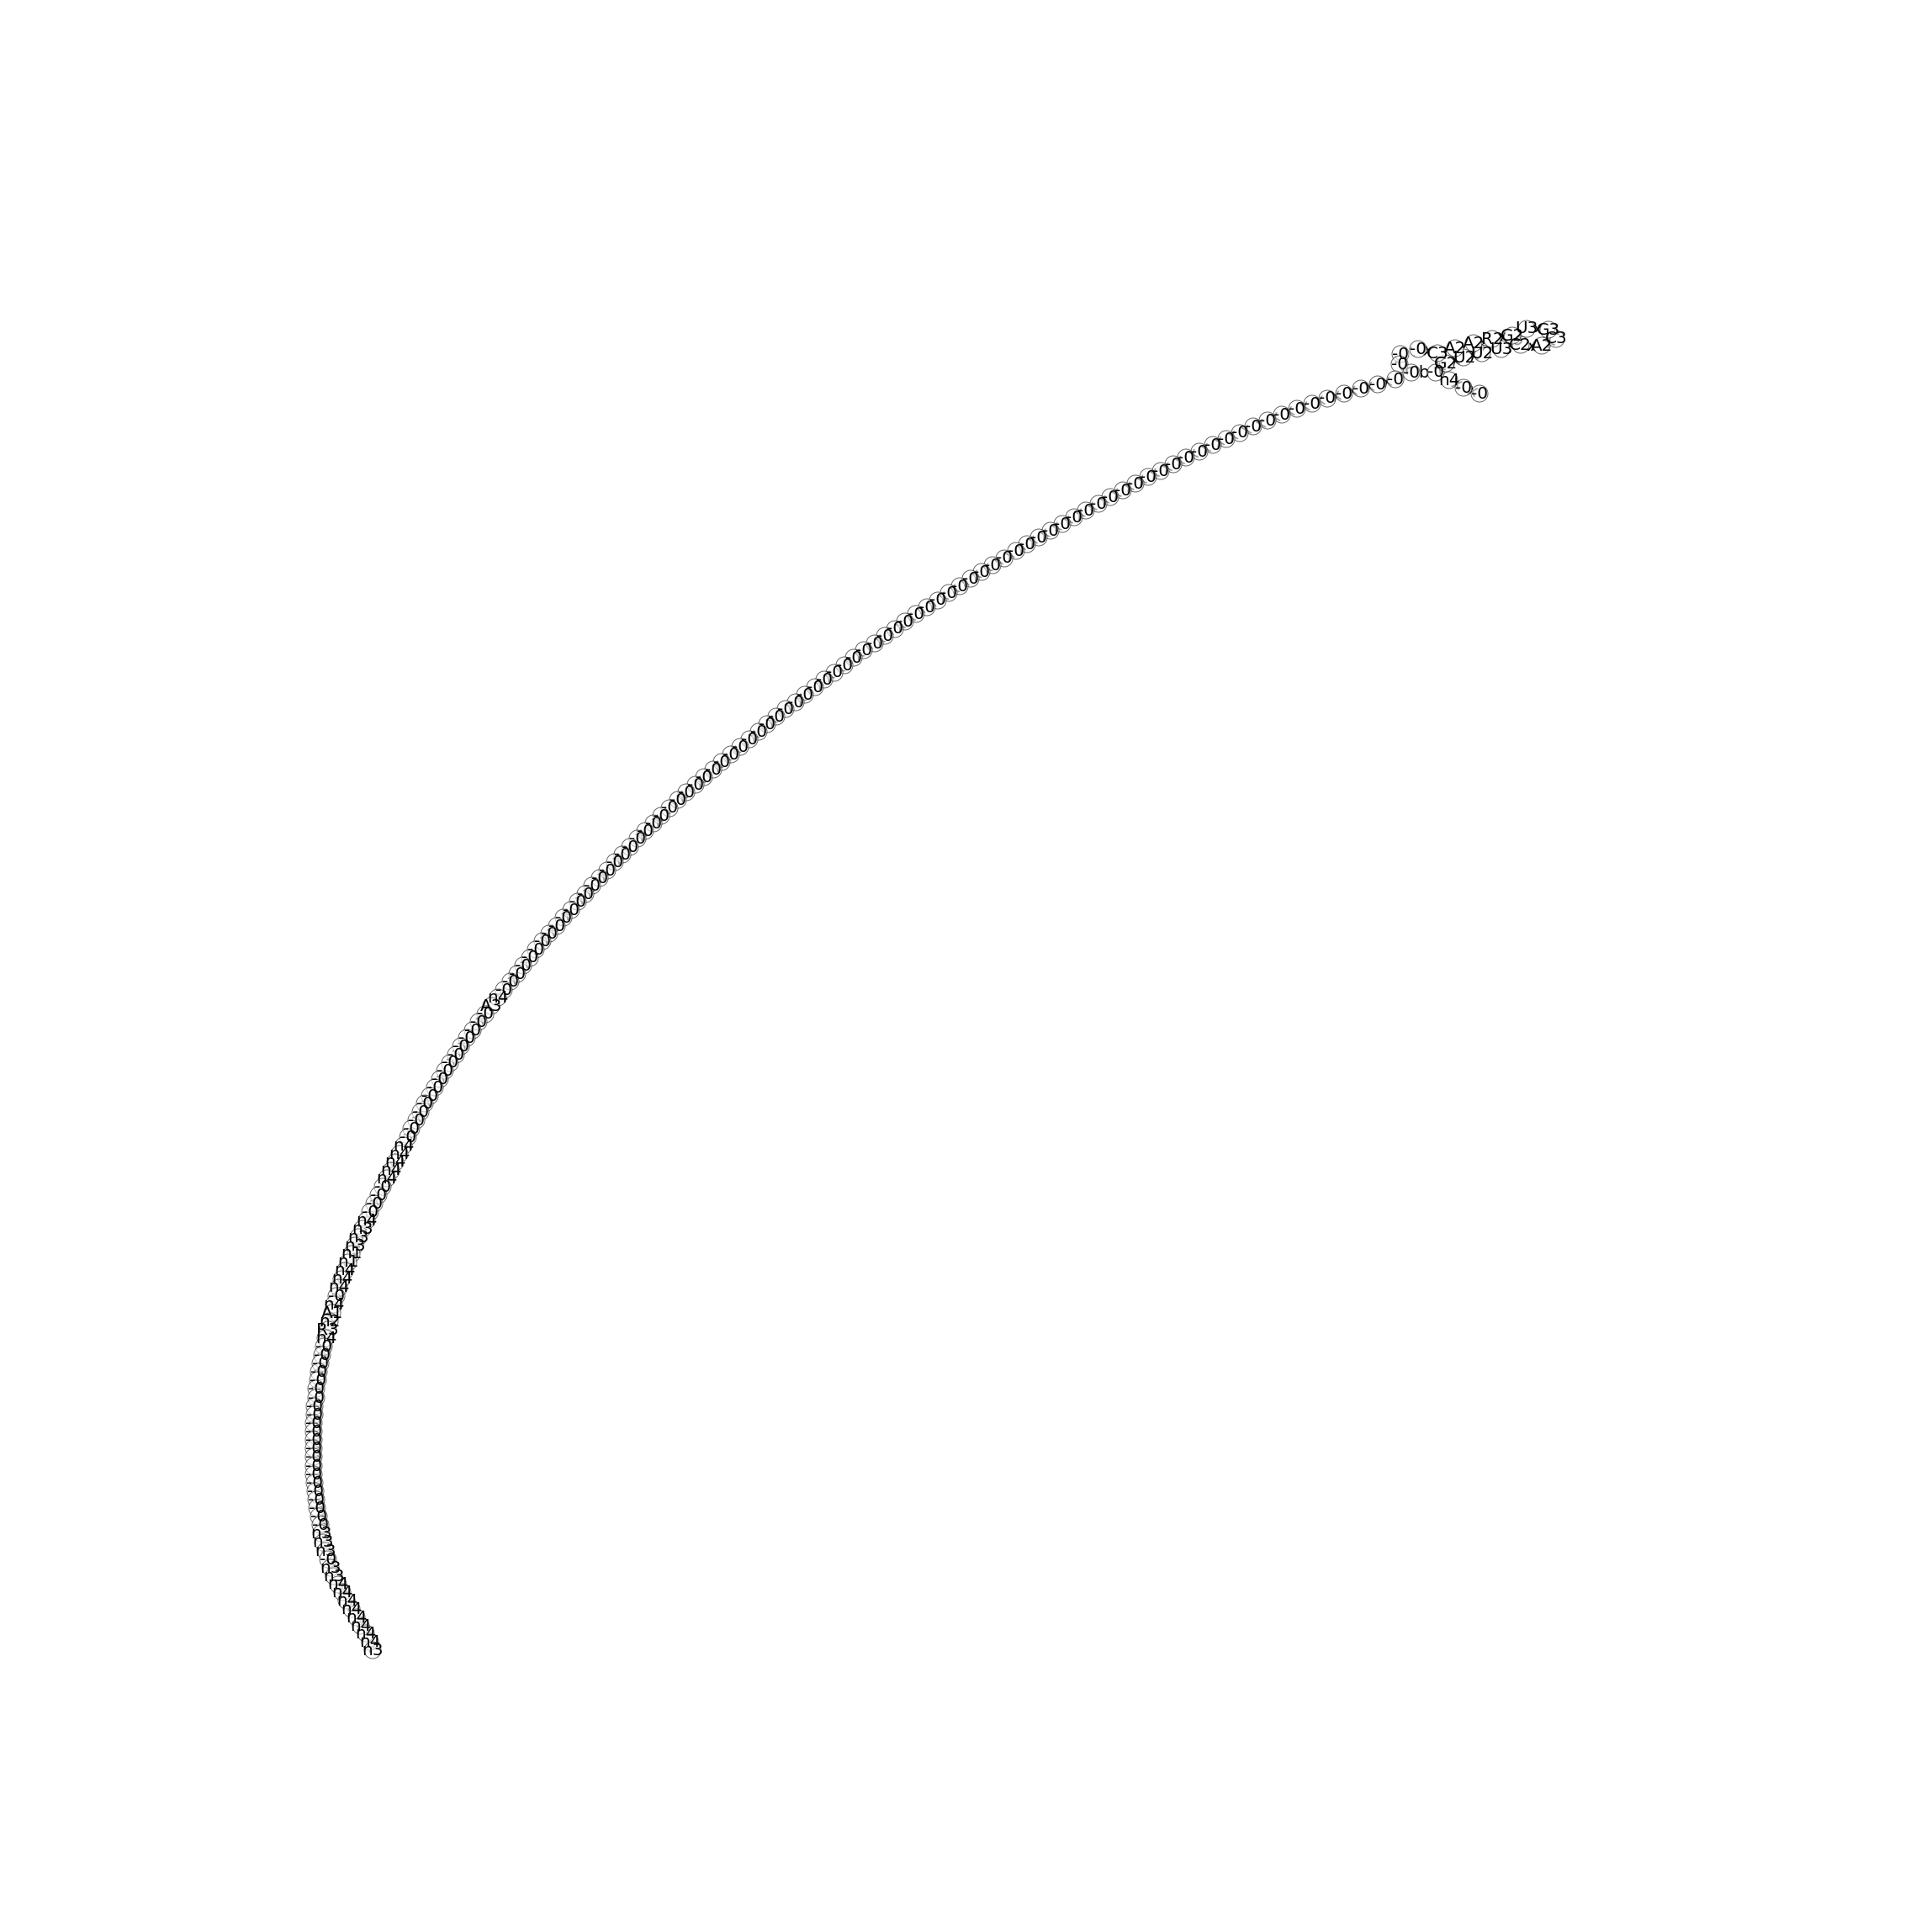

In [12]:
for G in pos_0_Graphs:
    display.draw_graph(G, size=40, node_size=400, font_size=20, node_border=True, prog='neato')
for G in neg_0_Graphs:
    display.draw_graph(G, size=40, node_size=400, font_size=20, node_border=True, prog='neato')
for G in pos_1_Graphs:
    display.draw_graph(G, size=40, node_size=400, font_size=20, node_border=True, prog='neato')
for G in neg_1_Graphs:
    display.draw_graph(G, size=40, node_size=400, font_size=20, node_border=True, prog='neato')

# Classification

## This Classification Class does:
- Create target file. 
- Do the modeling. 

### Make train test files

In [13]:
def make_train_test_data(pos_0_Graphs, pos_1_Graphs, neg_0_Graphs, neg_1_Graphs):

    X_train = [1]*len(pos_0_Graphs) + [-1]*len(neg_0_Graphs)
    X_test = X_train
    Y_train = [1]*len(pos_1_Graphs) + [-1]*len(neg_1_Graphs)
    Y_test = Y_train

    return X_train, Y_train, X_test, Y_test

In [14]:
pos_graphs = pos_0_Graphs + pos_1_Graphs
neg_graphs = neg_0_Graphs + neg_1_Graphs
train_testt = make_train_test_data(pos_0_Graphs, pos_1_Graphs, neg_0_Graphs, neg_1_Graphs)

In [20]:
'''Conversion
   -----------'''
'''load a target file'''

#import numpy as np
#for graph in pos_graphs:

    #for 
#y = [1]*len(pos_graphs) + [-1]*len(neg_graphs)
#y = np.asarray([int(value) for value in y])
#graphs = pos_Graphs + neg_Graphs

'load a target file'

In [ ]:
'''load data and convert it to graphs'''
from eden.converter.graph.gspan import gspan_to_eden
#graphs = gspan_to_eden('http://www.bioinf.uni-freiburg.de/~costa/bursi.gspan')
graphs = pos_Graphs + neg_Graphs
#print graphs

In [ ]:
'''Vectorizer
   ----------'''
'''setup the vectorizer'''

from eden.graph import Vectorizer
vectorizer = Vectorizer(complexity=3)
#print vectorizer

In [ ]:
'''extract features and build data matrix'''

%%time
X = vectorizer.transform(graphs)
print 'Instances: %d Features: %d with an avg of %d features per instance' % (X.shape[0], X.shape[1],  X.getnnz()/X.shape[0])

In [ ]:
'''Modelling
   -----------'''
'''Induce a predictor and evaluate its performance'''

%%time
#induce a predictive model
from sklearn.linear_model import SGDClassifier
predictor = SGDClassifier(average=True, class_weight='balanced', shuffle=True, n_jobs=-1)

from sklearn import cross_validation
scores = cross_validation.cross_val_score(predictor, X, y, cv=5, scoring='roc_auc')

import numpy as np
print('AUC ROC: %.4f +- %.4f' % (np.mean(scores),np.std(scores)))

# Divide Sto files based on their classes:

In [ ]:
'''seperate classes into diffeerent folders'''

def _classesToFolders(files_dir, partition_dir, pos_class_0_path, pos_class_1_path, neg_class_0_path, neg_class_1_path):
    pos_partition_file = "positive-partitions-test.tab"
    neg_partition_file = "negative-partitions-test.tab"

    tab_list = os.listdir(partition_dir)
    for tab_file in os.listdir(partition_dir):
        files_list = os.listdir(files_dir)
        
        for folder_name in os.listdir(files_dir):
            folder_path = os.path.join(files_dir, folder_name)
            
            if tab_file == pos_partition_file and folder_name == 'positives-sto':
                read_pos_tab = open(os.path.join(partition_dir, tab_file), 'r')

                for line in read_pos_tab:
                    line_parts= line.split()
                    file_name = line_parts[0]
                    file_class_num = line_parts[1]

                    '''copy file to the pos_class_0 folder'''
                    if file_class_num == '0':
                        for file in os.listdir(folder_path):
                            file_path = os.path.join(folder_path, file)
                            file = ntpath.splitext( ntpath.basename(file_path))[0]
                            if fnmatch.fnmatch(file, file_name):
                                shutil.copy(file_path, pos_class_0_abs_path)
                            
                    '''copy file to the pos_class_1 folder'''
                    if file_class_num == '1':                      
                        for file in os.listdir(folder_path):
                            file_path = os.path.join(folder_path, file)
                            file = ntpath.splitext( ntpath.basename(file_path))[0]
                            if fnmatch.fnmatch(file, file_name):
                                shutil.copy(file_path, pos_class_1_abs_path)
                                
            if tab_file == neg_partition_file and folder_name == 'negatives-sto':
                read_neg_tab = open(os.path.join(partition_dir, tab_file), 'r')
                for line in read_neg_tab:
                    line_parts= line.split()
                    file_name = line_parts[0]
                    file_class_num = line_parts[1]
                    '''copy file to the pos_class_0 folder'''
                    if file_class_num == '0':
                        for file in os.listdir(folder_path):
                            file_path = os.path.join(folder_path, file)
                            file = ntpath.splitext( ntpath.basename(file_path))[0]
                            if fnmatch.fnmatch(file, file_name):
                                shutil.copy(file_path, neg_class_0_abs_path)

                    '''copy file to the pos_class_1 folder'''
                    if file_class_num == '1':
                        for file in os.listdir(folder_path):
                            file_path = os.path.join(folder_path, file)
                            file = ntpath.splitext( ntpath.basename(file_path))[0]
                            if fnmatch.fnmatch(file, file_name):
                                shutil.copy(file_path, neg_class_1_abs_path)

In [ ]:
files_dir = "StoExamples/StoExmapleSmall"
partition_dir = "StoExamples/partitionsFiles"

pos_class_0_path = "StoExamples/StoClasses/pos_class_0"
pos_class_1_path = "StoExamples/StoClasses/pos_class_1"
neg_class_0_path = "StoExamples/StoClasses/neg_class_0"
neg_class_1_path = "StoExamples/StoClasses/neg_class_1"

files_abs_path = os.path.abspath(files_dir)
partition_abs_path = os.path.abspath(partition_dir)
pos_class_0_abs_path = os.path.abspath(pos_class_0_path)
pos_class_1_abs_path = os.path.abspath(pos_class_1_path)
neg_class_0_abs_path = os.path.abspath(neg_class_0_path)
neg_class_1_abs_path = os.path.abspath(neg_class_1_path)


Class_to_folder = _classesToFolders(files_abs_path, partition_abs_path, pos_class_0_abs_path, pos_class_1_abs_path, neg_class_0_abs_path, neg_class_1_abs_path)


# Note